#### Загрузка данных

In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [3]:
train_df = pd.read_csv("data/train.csv", index_col = "Id")
test_df = pd.read_csv('data/test.csv', index_col = "Id")

In [4]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Приведём все пропуски к единому значению

In [5]:
for c in train_df.columns:
    train_df[c] = train_df[c].apply(lambda x: None if x is np.nan else x)

Удалим выбросы, по площади

Создадим функцию преобразуюущую категориальные данные в численные

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

def factorize(df, factor_df, column, fill_na=None):
    factor_df[column] = df[column]
    if fill_na is not None:
        factor_df[column].fillna(fill_na, inplace=True)
    le.fit(factor_df[column].unique())
    factor_df[column] = le.transform(factor_df[column])
    return factor_df



Функция выполняющая one-hot encoding

In [7]:
def onehot(onehot_df, df, column_name, fill_na, drop_name):
    onehot_df[column_name] = df[column_name]
    if fill_na is not None:
        onehot_df[column_name].fillna(fill_na, inplace=True)

    dummies = pd.get_dummies(onehot_df[column_name], prefix="_" + column_name)
    
    # Dropping one of the columns actually made the results slightly worse.
    # if drop_name is not None:
    #     dummies.drop(["_" + column_name + "_" + drop_name], axis=1, inplace=True)

    onehot_df = onehot_df.join(dummies)
    onehot_df = onehot_df.drop([column_name], axis=1)
    return onehot_df

In [8]:
def show_col(col):
    global train_df
    
    na_sum = train_df[col].isna().sum()
    print("Количество пропущенных значений в тренировочном датасете = {}".format(na_sum))
    na_sum = test_df[col].isna().sum()
    print("Количество пропущенных значений в тестовом датасете = {}".format(na_sum))
    
    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1)
    train_df[col].hist(bins = 20)
    plt.xlabel(col)
    plt.ylabel("Количество наблюдений")
    plt.title("Train")
    
    plt.subplot(1,2,2)
    test_df[col].hist(bins = 20)
    plt.xlabel(col)
    plt.ylabel("Количество наблюдений")
    plt.title("Test")
    plt.show()

In [9]:
def show_different_values(col):
    global train_df, test_df
    
    res = set(train_df[col].unique()) ^ set(test_df[col].unique())
    return list(res)
    

#### Рассмотрим данные

В соответствии с 'data_description.txt' преобразуем все данные и заполним пропуски. Построим пробный вариант тренировочного датaфрейма. На основании проделанной работы создадим функцию, создающую выборки для обучения и тестирования модели.

In [10]:
train_df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [11]:
all_df = pd.DataFrame(index = train_df.index)   
onehot_df = pd.DataFrame(index = train_df.index)

##### LotFrontage
LotFrontage -  протяжёность улицы (футы), примыкающей к участку

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


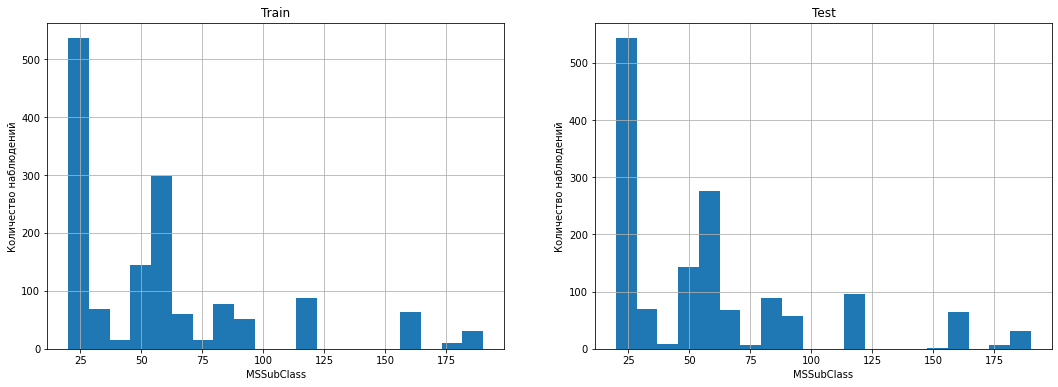

In [12]:
show_col("MSSubClass")

In [13]:
train_df["MSSubClass"].value_counts()\
.iloc[-1:]

40    4
Name: MSSubClass, dtype: int64

In [14]:
all_df = factorize(train_df, all_df, "MSSubClass")
onehot_df = onehot(onehot_df, train_df, "MSSubClass", None, 40)

##### MSZoning
'MSZoning' - Определяет общую классификацию зонирования продажи.

In [15]:
all_df["MSZoning"] = train_df["MSZoning"] 

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 4


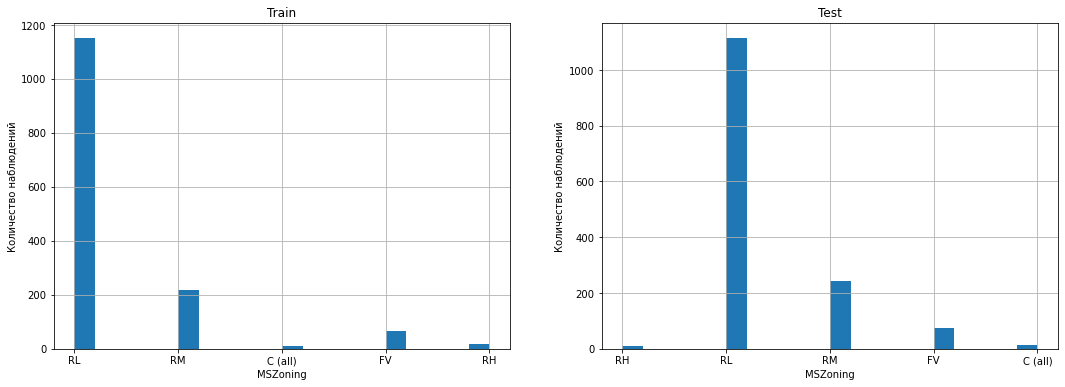

In [16]:
show_col("MSZoning")

В тренировочном наборе нет  ряда значений. Значит преобразуем данные исходя из описания. Возможные пропуски заменим 

In [17]:
d =  {None : 0, 'A' : 1, 'C' : 2, 'FV' : 3, 'I': 4, 'RH' : 5,
        'RL' : 6, "RP" : 7, 'RM' : 8}
         
all_df["MSZoning"] = train_df["MSZoning"].map(d)
onehot_df = onehot(onehot_df, train_df, "MSZoning", "RL", "RH")

##### LotFrontage
'LotFrontage' - Линейные футы улицы, примыкающей к участку

Количество пропущенных значений в тренировочном датасете = 259
Количество пропущенных значений в тестовом датасете = 227


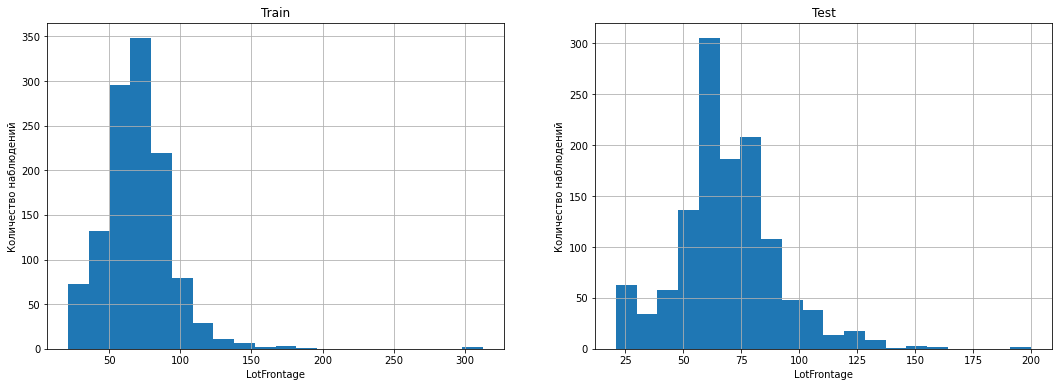

In [18]:
show_col("LotFrontage")

'LotFrontage'  >  250 - выброс.    
LotFrontage - напрямую завивисито от района, в котором находится дом.     
Поэтому пропуски заполним медианными значениями для каждого района

In [19]:
lot_frontage_by_neighborhood = train_df["LotFrontage"].groupby(train_df["Neighborhood"])

all_df["LotFrontage"] = train_df["LotFrontage"]   
for key, group in lot_frontage_by_neighborhood:
    idx = (train_df["Neighborhood"] == key) & (train_df["LotFrontage"].isnull())
    all_df.loc[idx, "LotFrontage"] = group.median()

In [20]:
file = open("outlires.txt", "w")
file.write("Outlires description \n")
file.close()

Заведём фалик, где опишем все отклонения

In [21]:
def write_outlires_inf(text):
    with open("outlires.txt", "a") as file:
        file.write(text)
        file.write("\n")

In [22]:
write_outlires_inf("'LotFrontage' > 250")

##### LotArea
'LotArea' - Размер участка в квадратных футах

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


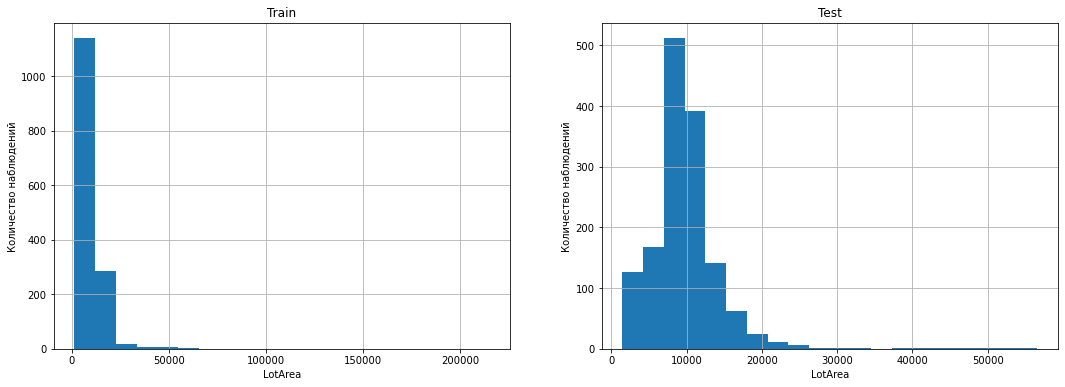

In [23]:
show_col("LotArea")

In [24]:
write_outlires_inf("'LotArea' > 100000")

Зафиксируем выброс 'LotArea' > 100000. 

Попробуем прологарифмировать данный признак

<AxesSubplot:>

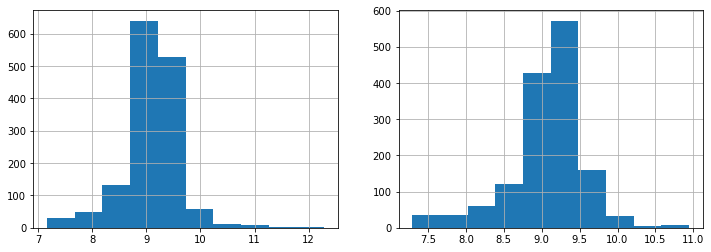

In [25]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
train_df["LotArea"].apply(np.log).hist()
plt.subplot(1,2,2)
test_df["LotArea"].apply(np.log).hist()

C:\Users\Grigorii\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Grigorii\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


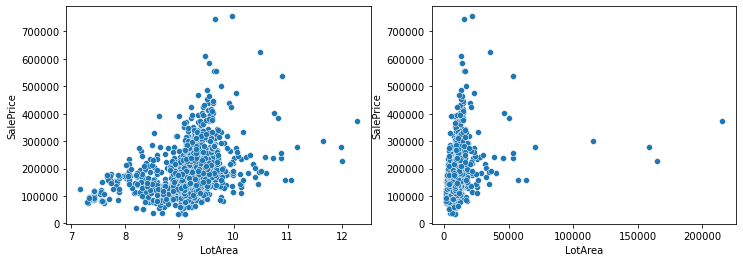

In [26]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.scatterplot(train_df["LotArea"].apply(np.log1p), train_df["SalePrice"])

plt.subplot(1,2,2)
sns.scatterplot(train_df["LotArea"], train_df["SalePrice"])
plt.show()

Создание логарифмированных признаков может иметь положительный эффект

In [27]:
all_df["LotArea"] = train_df["LotArea"]
all_df["LotAreaLog"] = all_df["LotArea"].apply(np.log1p)

##### Street
'Street' - Тип дороги, ведущей к объекту недвижимости

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


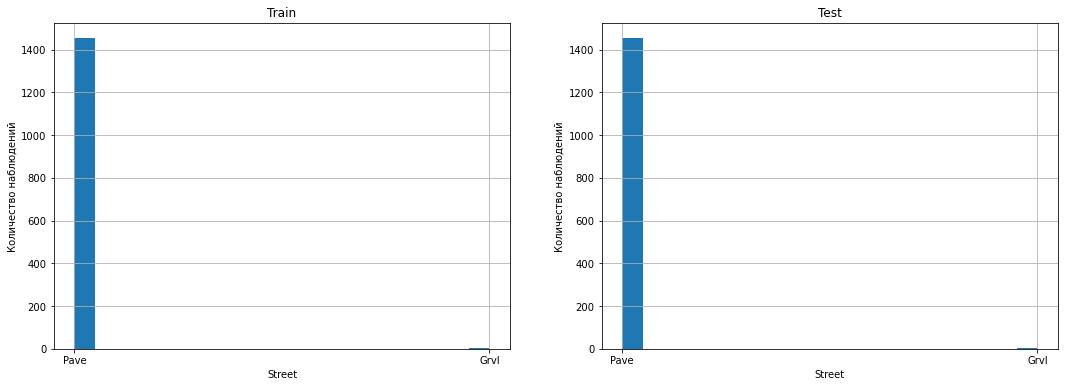

In [28]:
show_col("Street")

Налицо дисбаланс

In [29]:
imbalanced  = []
imbalanced.append("Street")

In [30]:
onehot_df = onehot(onehot_df, train_df, "Street", None, "Grvl")

##### Alley
'Alley' - Тип подъездной аллеи к собственности

Количество пропущенных значений в тренировочном датасете = 1369
Количество пропущенных значений в тестовом датасете = 1352


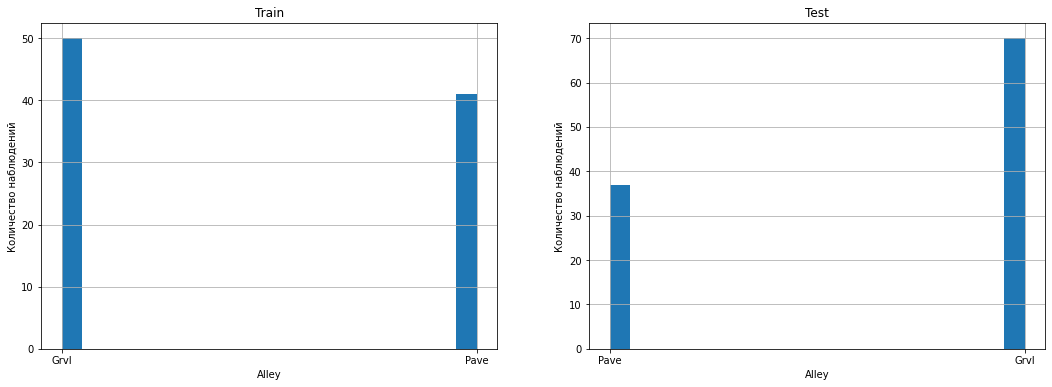

In [31]:
show_col("Alley")

В данном случе логично создать признак - есть ли подъездная аллея.

In [32]:
train_df.fillna({'Alley':"nan"})\
.groupby("Alley")\
.agg({"SalePrice" : ['mean', "std"]})

SalePrice              
                mean           std
Alley                             
Grvl   122219.080000  34780.780734
Pave   168000.585366  38370.375243
nan    183452.131483  80667.145180

In [33]:
onehot_df = onehot(onehot_df, train_df, "Alley", "None", "Grvl")

##### LotShape
'LotShape' - Общая форма недвижимости

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


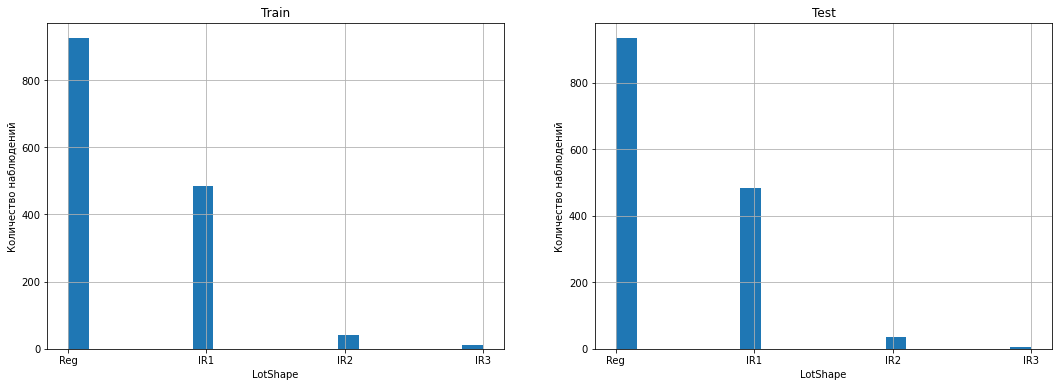

In [34]:
show_col('LotShape')

В данном случае логично создать признак является ли форма участка регулярной. А так же создать бинарне признаки  из 'Reg', 'IR1', 'IR2'. 'IR3' имеет отношение к слишком маленькому числу наблюдений. 

In [35]:
onehot_df = onehot(onehot_df, train_df, "LotShape", None, "IR3")

##### LandContour
'LandContour' - характеризует кривизну участка 

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


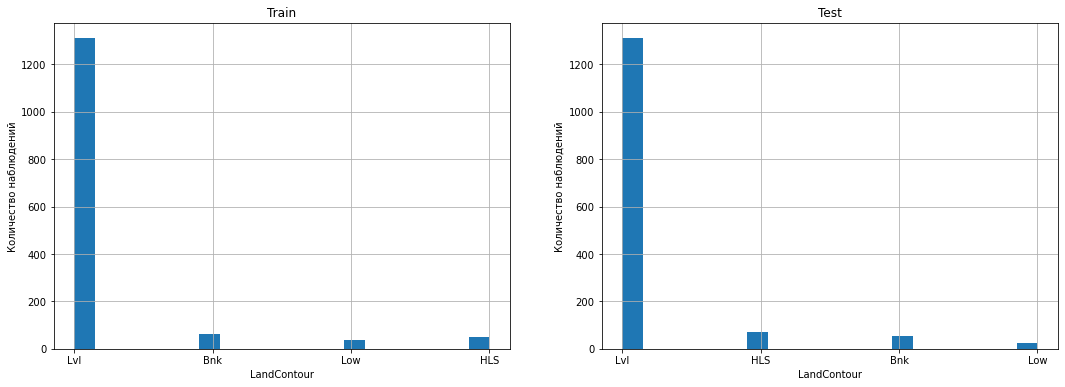

In [36]:
show_col('LandContour')

Тут так же подйдёт one_hot_encoding

In [37]:
onehot_df = onehot(onehot_df, train_df, "LandContour", None, "Low")

##### Utilities
'Utilities' - Тип доступных коммунальных услуг

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 2


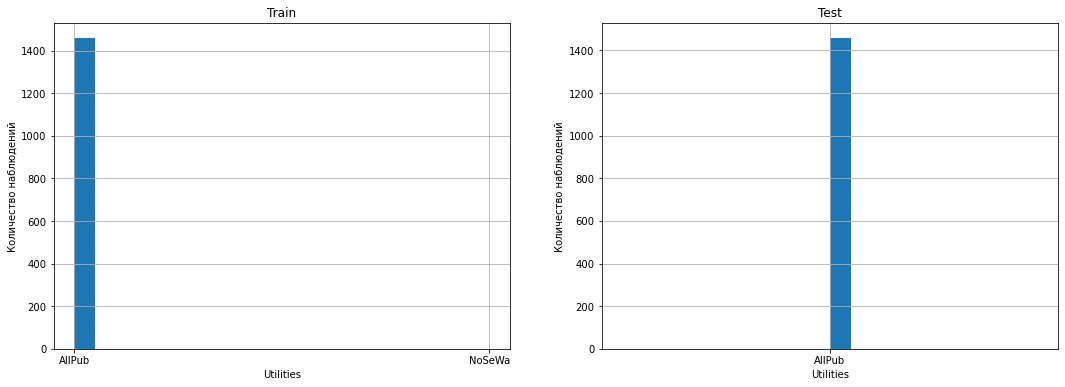

In [38]:
show_col('Utilities')

Лишний признак. почти вес наблюдения AllPub

##### LotConfig

'LotConfig' - конфигурация участка

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


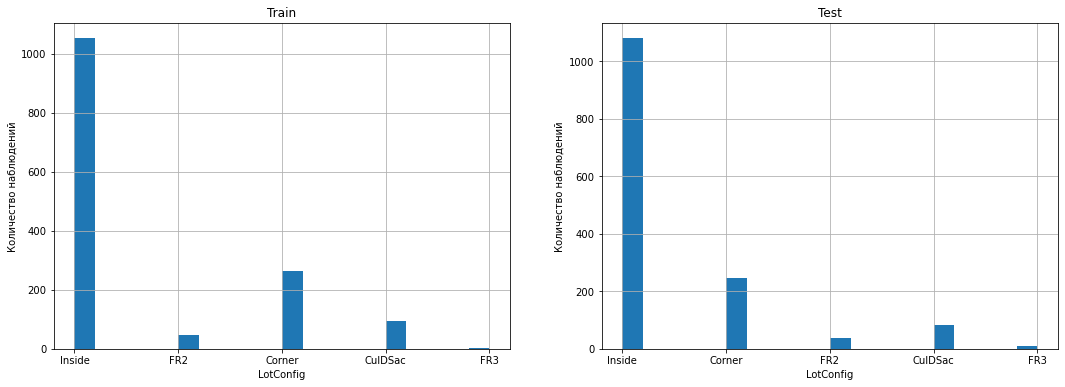

In [39]:
show_col('LotConfig')

В данном случае можно использовать как нумерацию категорий, так и бинаризацию

In [40]:
onehot_df = onehot(onehot_df, train_df, "LotConfig", None, "FR3")

In [41]:
all_df = factorize(train_df, all_df, "LotConfig")

##### LandSlope
'LandSlope' - уклон участка

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


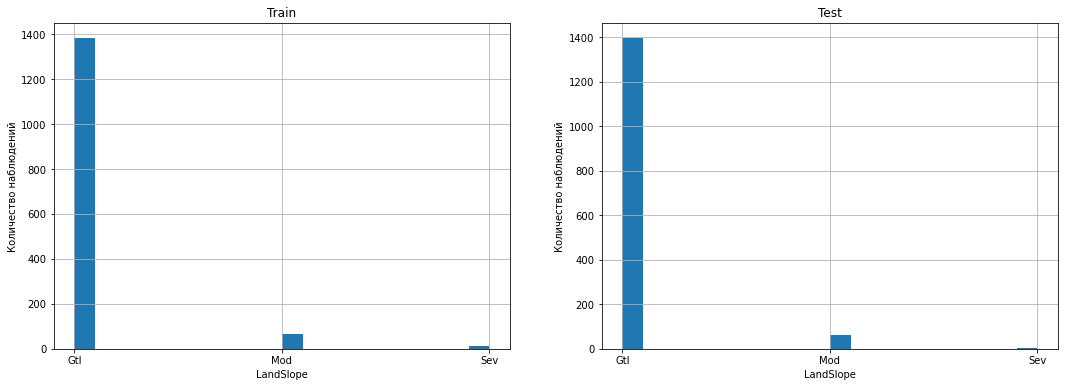

In [42]:
show_col('LandSlope')

Однозначно бинаризация

In [43]:
onehot_df = onehot(onehot_df, train_df, "LandSlope", None, "Sev")

##### Neighborhood
'Neighborhood' - Район

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


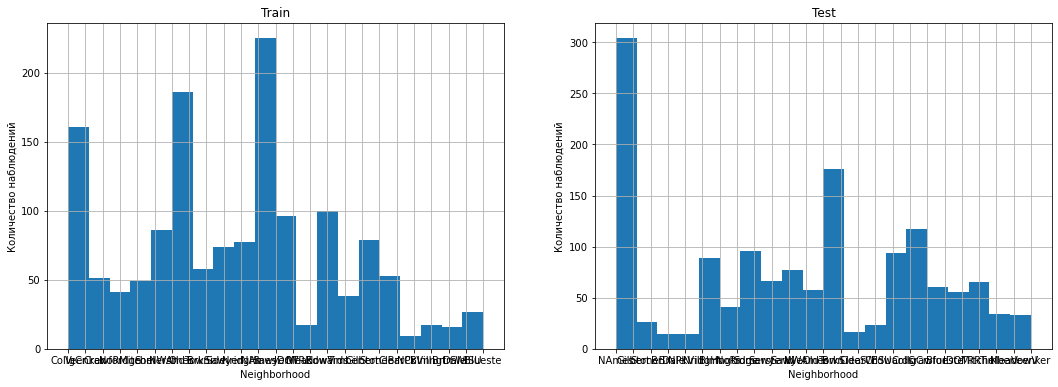

In [44]:
show_col("Neighborhood")

In [45]:
train_df.\
groupby('Neighborhood').\
agg({'SalePrice' : ["median", "sum"]}).\
sort_values(by = ('SalePrice', 'median'))

SalePrice          
                median       sum
Neighborhood                    
MeadowV          88000   1675800
IDOTRR          103000   3704580
BrDale          106000   1671900
OldTown         119000  14489459
Edwards         121750  12821970
BrkSide         124300   7240375
Sawyer          135000  10122692
Blueste         137500    275000
SWISU           139500   3564784
NAmes           140000  32815593
NPkVill         146000   1284250
Mitchel         153500   7657236
SawyerW         179900  11006792
Gilbert         181000  15235506
NWAmes          182900  13800655
Blmngtn         191000   3312805
CollgCr         197200  29694866
ClearCr         200250   5951832
Crawfor         200624  10741861
Veenker         218000   2626500
Somerst         225500  19382666
Timber          228475   9205403
StoneBr         278000   7762475
NoRidge         301500  13747108
NridgHt         315000  24352838

In [46]:
set(train_df['Neighborhood'].unique()) == set(test_df['Neighborhood'].unique())

True

In [47]:
all_df = factorize(train_df, all_df, "Neighborhood")

In [48]:
neighborhood_map = {
'MeadowV' : 0,          #88000
'IDOTRR' : 1,           #103000
'BrDale' : 1,           #106000
'OldTown' : 1,          #119000
'Edwards' : 1,          #121750
'BrkSide' : 1,          #124300
'Sawyer' : 1,           #135000
'Blueste' : 1,          #137500
'SWISU' : 2,            #139500
'NAmes' : 2,            #140000
'NPkVill' : 2,          #146000
'Mitchel' : 2,          #153500
'SawyerW' : 2,          #179900
'Gilbert' : 2,          #181000
'NWAmes' : 2,           #182900
'Blmngtn' : 2,          #191000
'CollgCr' : 2,          #197200
'ClearCr' : 3,          #200250
'Crawfor' : 3,          #200624
'Veenker' : 3,          #218000
'Somerst' : 3,          #225500
'Timber' : 3,           #228475
'StoneBr' : 4,          #278000
'NoRidge' : 4,          #301500
'NridgHt' : 4          #315000
}

In [49]:
all_df["NeighborhoodBin"] = train_df["Neighborhood"].map(neighborhood_map)

In [50]:
all_df = factorize(train_df, all_df, "Neighborhood")

In [51]:
all_df.loc[train_df.Neighborhood == 'NridgHt', "Neighborhood_Good"] = 1
all_df.loc[train_df.Neighborhood == 'Crawfor', "Neighborhood_Good"] = 1
all_df.loc[train_df.Neighborhood == 'StoneBr', "Neighborhood_Good"] = 1
all_df.loc[train_df.Neighborhood == 'Somerst', "Neighborhood_Good"] = 1
all_df.loc[train_df.Neighborhood == 'NoRidge', "Neighborhood_Good"] = 1
all_df.loc[train_df.Neighborhood == 'Timber', "Neighborhood_Good"] = 1
all_df.loc[train_df.Neighborhood == 'Veenker', "Neighborhood_Good"] = 1
all_df["Neighborhood_Good"].fillna(0, inplace=True)


##### Condition1
'Condition1' - Близость к различным условиям

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


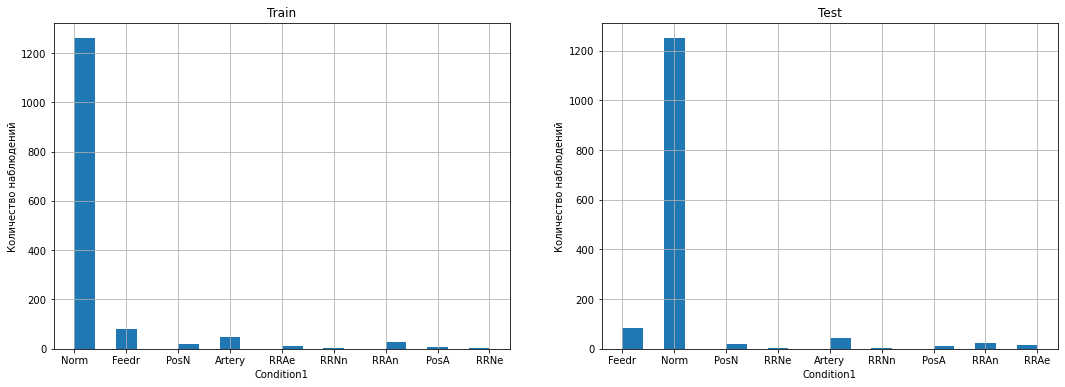

In [52]:
show_col('Condition1')

In [53]:
all_df = factorize(train_df, all_df, "Condition1")
onehot_df = onehot(onehot_df, train_df, "Condition1", None, "RRNe")

##### Condition2
'Condition2' - Близость к различным условиям

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


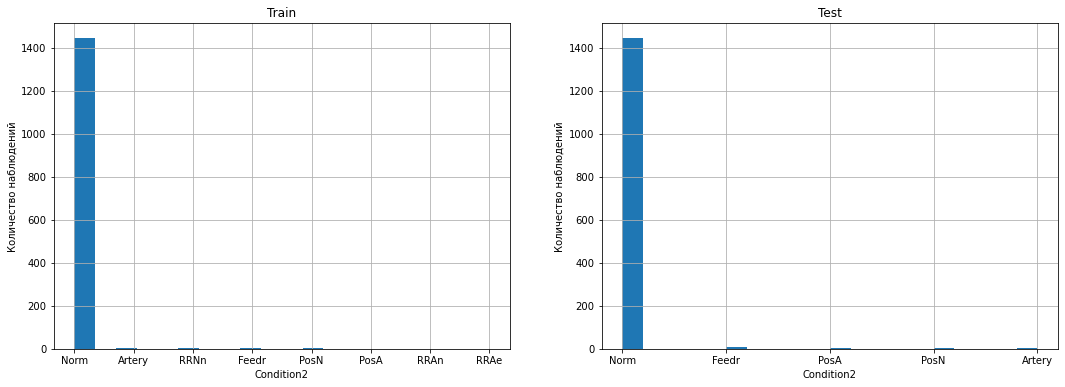

In [54]:
show_col('Condition2')

In [55]:
onehot_df = onehot(onehot_df, train_df, "Condition2", None, "PosA")

##### BldgType
'BldgType' - Тип жилья

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


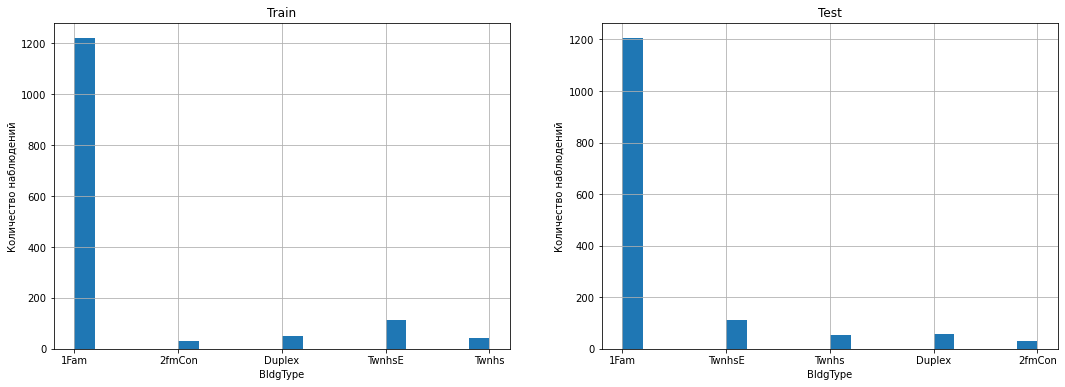

In [56]:
show_col('BldgType')

In [57]:
all_df = factorize(train_df, all_df, "BldgType")
onehot_df = onehot(onehot_df, train_df, "BldgType", None, "2fmCon")

##### HouseStyle
'HouseStyle' - Стиль жилища

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


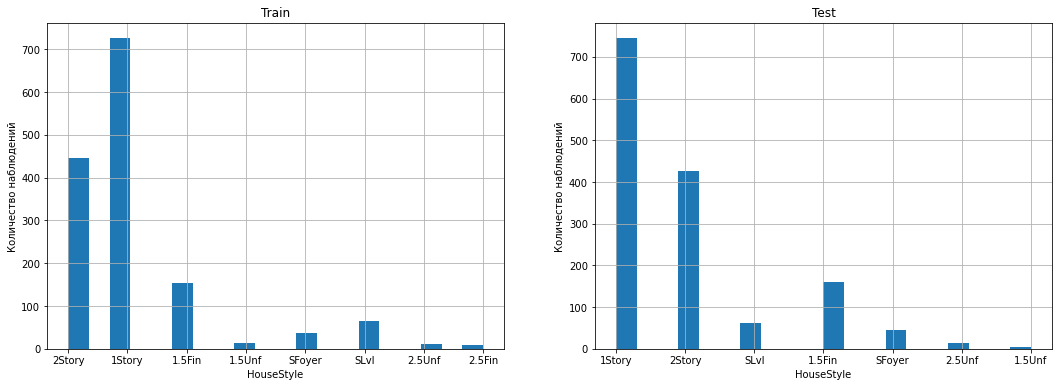

In [58]:
show_col('HouseStyle')

In [59]:
train_df["HouseStyle"].value_counts()

1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64

In [60]:
all_df = factorize(train_df, all_df, "HouseStyle")
onehot_df = onehot(onehot_df, train_df, "HouseStyle", None, "2.5Fin")

##### OverallQual
'OverallQual' - Оценивает общий материал и отделку дома.

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


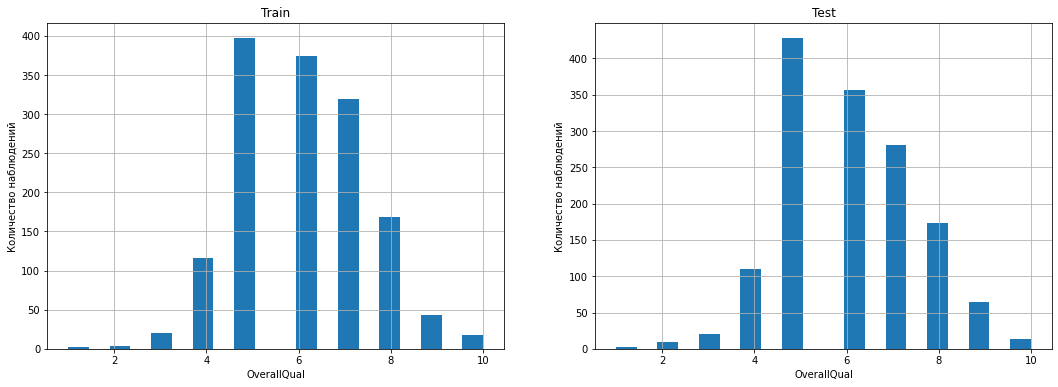

In [61]:
show_col('OverallQual')

In [62]:
all_df["OverallQual"] = train_df["OverallQual"]

##### OverallCond
'OverallCond' - Оценивает общее состояние дома

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


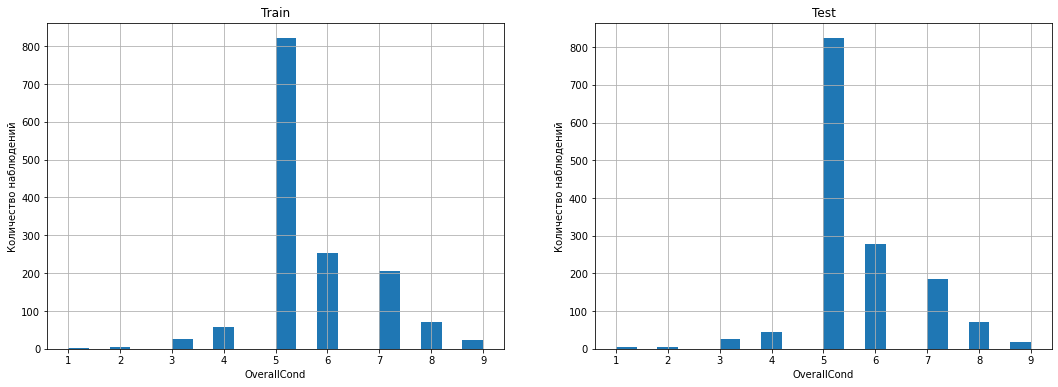

In [63]:
show_col('OverallCond')

In [64]:
all_df["OverallCond"] = train_df["OverallCond"]

##### YearBuilt
'YearBuilt' - Первоначальная дата строительства

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


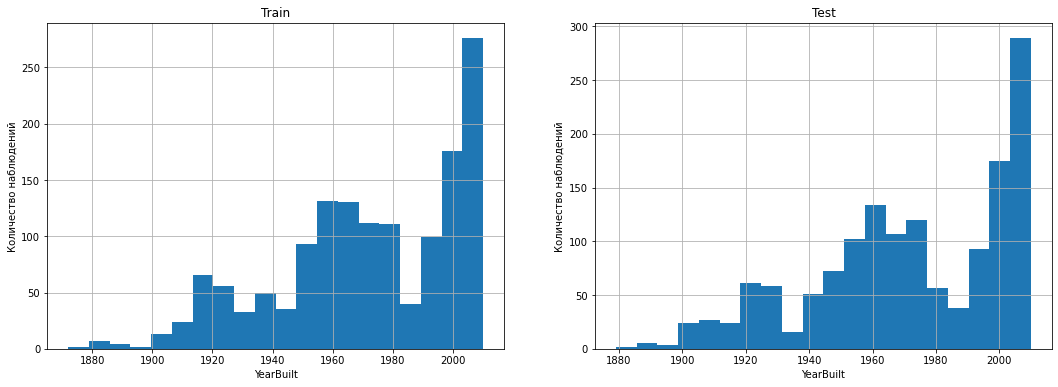

In [65]:
show_col('YearBuilt')

In [66]:
all_df["YearBuilt"] = train_df["YearBuilt"]

##### YearRemodAdd
'YearRemodAdd' - Дата перестройки (та же, что и дата строительства, если нет перестройки или дополнений)

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


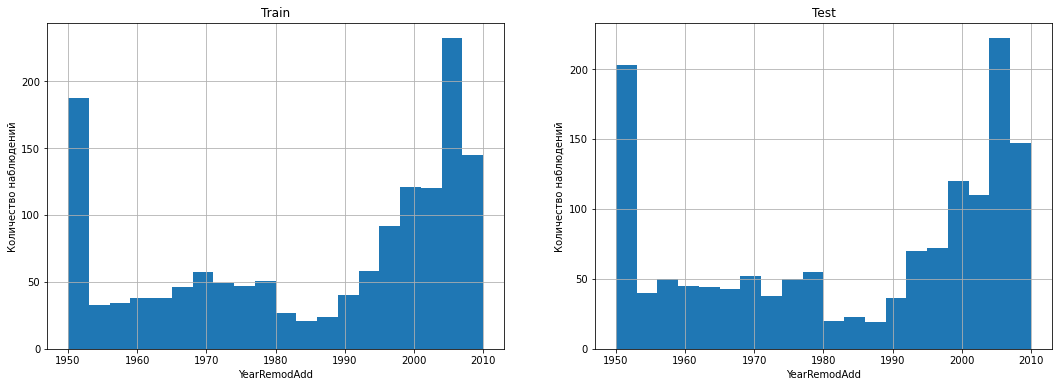

In [67]:
show_col('YearRemodAdd')

In [68]:
all_df["YearRemodAdd"] = train_df["YearRemodAdd"]

##### RoofStyle
RoofStyle - Тип крыши

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


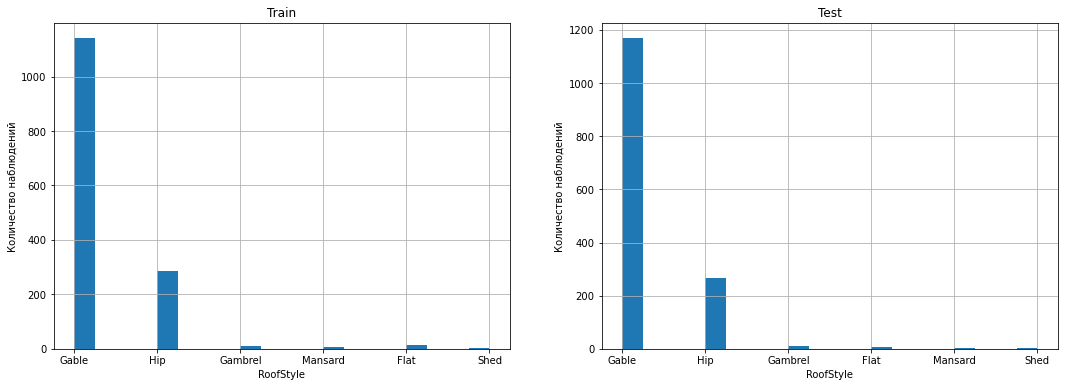

In [69]:
show_col('RoofStyle')

In [70]:
all_df = factorize(train_df, all_df, "RoofStyle")
onehot_df = onehot(onehot_df, train_df, "RoofStyle", None, "Shed")

##### RoofMatl
'RoofMatl' - Материал крыши

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


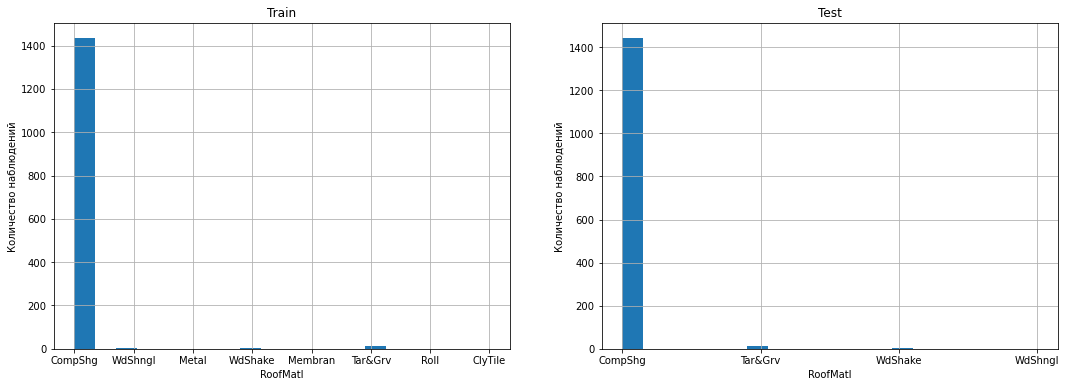

In [71]:
show_col('RoofMatl')

In [72]:
onehot_df = onehot(onehot_df, train_df, "RoofMatl", None, "WdShngl")

Посмотрим какие данные отсутствуют в тестовом датасете

In [73]:
set(train_df['RoofMatl'].unique()) ^ set(test_df['RoofMatl'].unique())

{'ClyTile', 'Membran', 'Metal', 'Roll'}

In [74]:
drop_cols = set(train_df['RoofMatl'].unique()) ^ set(test_df['RoofMatl'].unique())
drop_cols = list(drop_cols)
drop_cols = ["_RoofMatl_{}".format(x) for x in drop_cols]

onehot_df.drop(drop_cols, axis = 1, inplace = True)

In [75]:
one_hot_drop = []
one_hot_drop += drop_cols

##### Exterior1st
'Exterior1st' - Наружное покрытие на доме

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 1


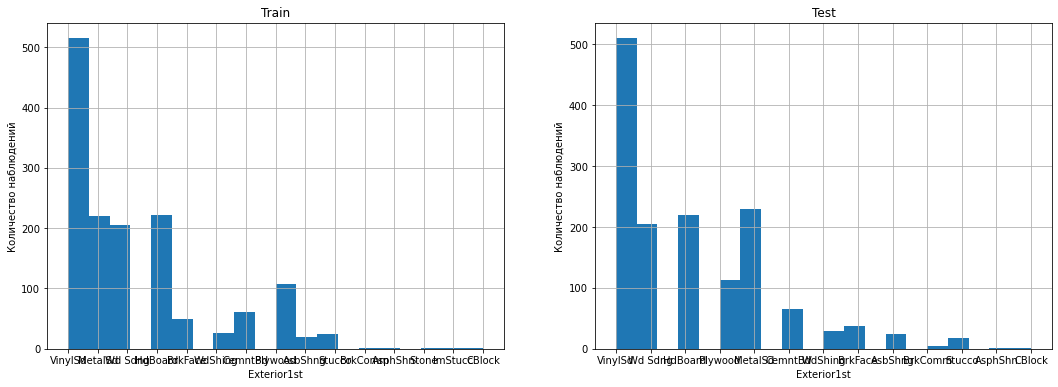

In [76]:
show_col('Exterior1st')

In [77]:
all_df = factorize(train_df, all_df, "Exterior1st", "Other")
onehot_df = onehot(onehot_df, train_df, "Exterior1st", "VinylSd", "CBlock")

In [78]:
show_different_values('Exterior1st')

[nan, 'ImStucc', 'Stone']

In [79]:
test_df['Exterior1st'].value_counts(dropna= False)

VinylSd    510
MetalSd    230
HdBoard    220
Wd Sdng    205
Plywood    113
CemntBd     65
BrkFace     37
WdShing     30
AsbShng     24
Stucco      18
BrkComm      4
NaN          1
AsphShn      1
CBlock       1
Name: Exterior1st, dtype: int64

In [80]:
drop_cols = show_different_values('Exterior1st')
drop_cols = ["_Exterior1st_{}".format(x) for x in drop_cols[1:]]

onehot_df.drop(drop_cols, axis = 1, inplace = True)

In [81]:
one_hot_drop += drop_cols

##### Exterior2nd
'Exterior2nd' - Наружное покрытие дома (если более одного материала)

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 1


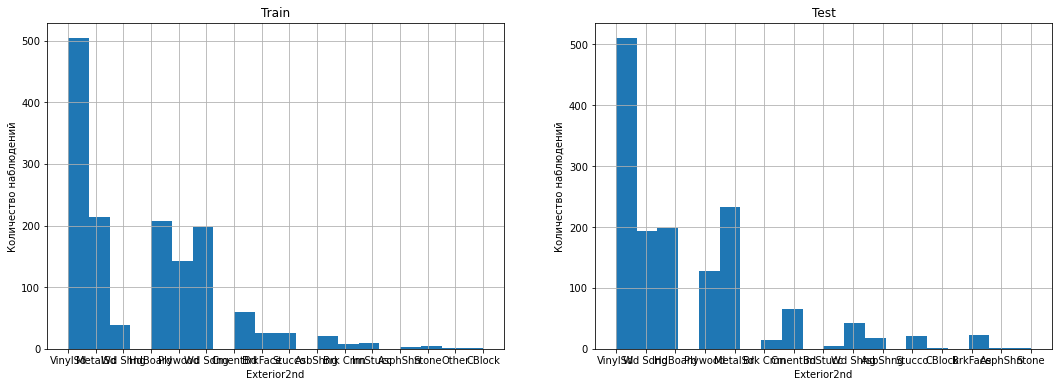

In [82]:
show_col('Exterior2nd')

In [83]:
all_df = factorize(train_df, all_df, "Exterior2nd", "Other")
onehot_df = onehot(onehot_df, train_df, "Exterior2nd", "VinylSd", "CBlock")

In [84]:
show_different_values('Exterior2nd')

[nan, 'Other']

In [85]:
drop_cols = show_different_values('Exterior2nd')
drop_cols = ["_Exterior2nd_{}".format(x) for x in drop_cols[1:]]

onehot_df.drop(drop_cols, axis = 1, inplace = True)

##### MasVnrType
'MasVnrType' - Тип каменной кладки

Количество пропущенных значений в тренировочном датасете = 8
Количество пропущенных значений в тестовом датасете = 16


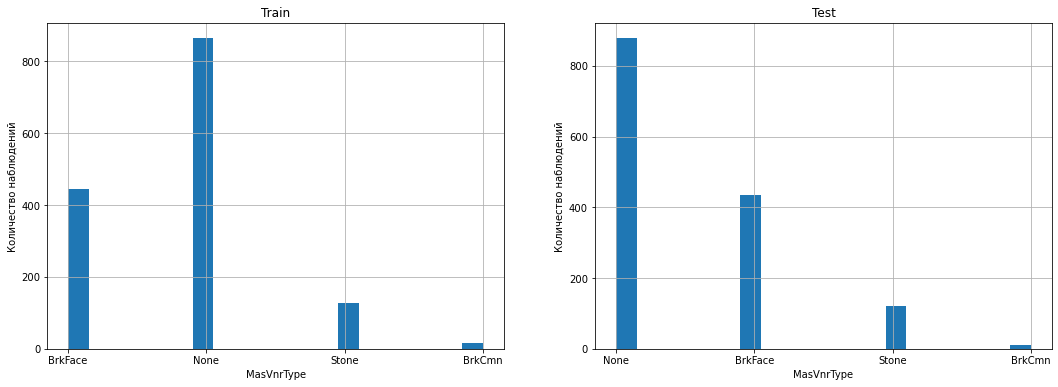

In [86]:
show_col('MasVnrType')

In [87]:
((train_df['MasVnrType'] == 'None') & (train_df['MasVnrArea'] != 0) ).sum()

5

Тое есть если площадь кладки больше нуля, а тип кладки "None", то заполним пропуски категорией "BrkFace" (кирпичная облицовка) из описания.

In [88]:
temp_df = train_df[["MasVnrType", "MasVnrArea"]].copy()
idx = temp_df[["MasVnrType", "MasVnrArea"]].\
apply(lambda x: ((x[0] == "None") | (x[0] is None)) & (x[1] > 0 ), axis = 1)

temp_df.loc[idx, 'MasVnrType'] = 'BrkFace'

In [89]:
all_df = factorize(temp_df, all_df, "MasVnrType", "None")
onehot_df = onehot(onehot_df, train_df, "MasVnrType", "None", "BrkCmn")

##### MasVnrArea
'MasVnrArea' - Площадь кладки в квадратных футах

Количество пропущенных значений в тренировочном датасете = 8
Количество пропущенных значений в тестовом датасете = 15


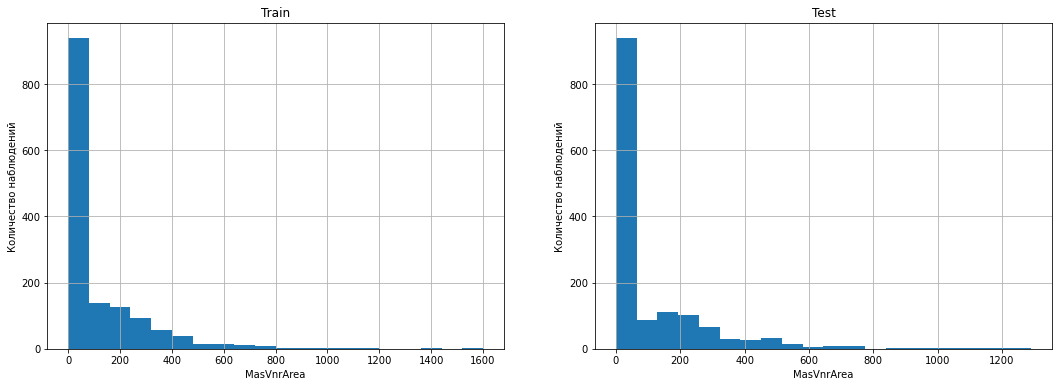

In [90]:
show_col('MasVnrArea')

In [91]:
write_outlires_inf("'MasVnrArea' > 1400")

In [92]:
all_df["MasVnrArea"] = train_df["MasVnrArea"]
all_df["MasVnrArea"].fillna(0, inplace=True)

Напрашивается бинарный признак

In [93]:
all_df["HasMasVnr"] = (all_df["MasVnrArea"] == 0).apply(int)

##### ExterQual
'ExterQual' - Оценивает качество материала экстерьера

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


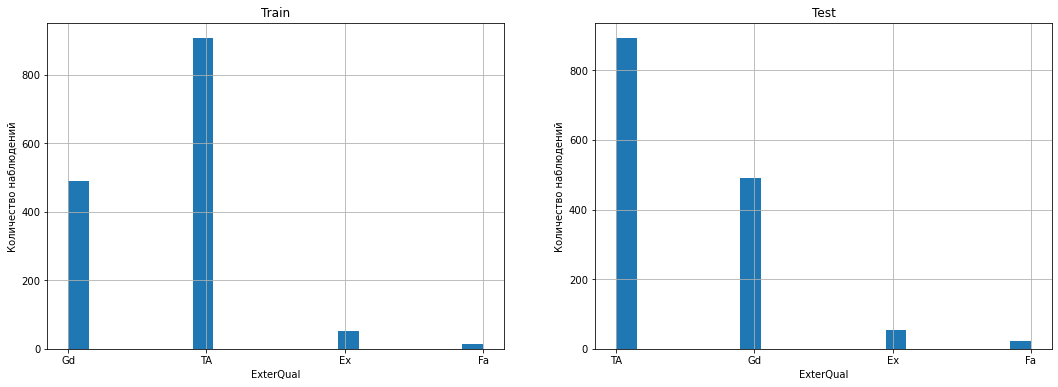

In [94]:
show_col('ExterQual')

Заведём словарь для хранения оценок качества

In [95]:
qual_dict = {None: 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}

In [96]:
all_df["ExterQual"] = train_df["ExterQual"].map(qual_dict).astype(int)

In [97]:
onehot_df = onehot(onehot_df, train_df, "ExterQual", "None", "Ex")

##### ExterCond
'ExterCond' - Оценивает текущее состояние материала на внешней стороне

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


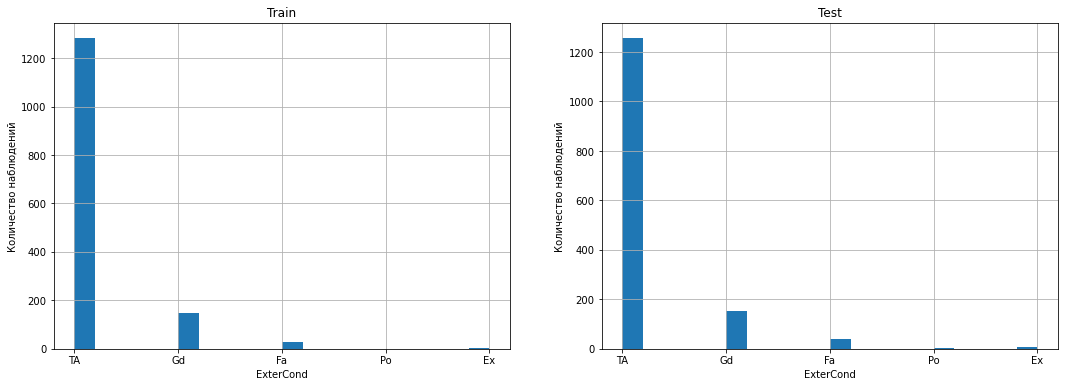

In [98]:
show_col('ExterCond')

In [99]:
all_df["ExterCond"] = train_df["ExterCond"].map(qual_dict).astype(int)
onehot_df = onehot(onehot_df, train_df, "ExterCond", "None", "Ex")

##### Foundation
'Foundation' - Тип фундамента

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


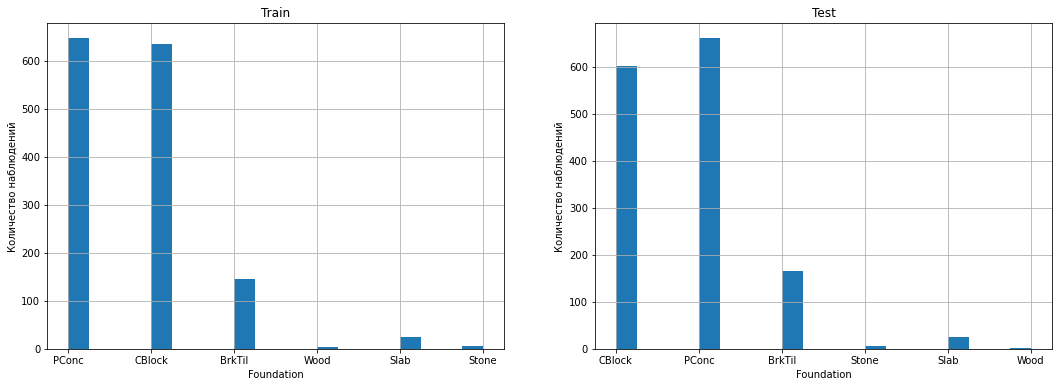

In [100]:
show_col('Foundation')

In [101]:
all_df = factorize(train_df, all_df, "Foundation")
onehot_df = onehot(onehot_df, train_df, "Foundation", None, "Wood")

##### BsmtQual
'BsmtQual' - Оценивает высоту подвального помещения

Количество пропущенных значений в тренировочном датасете = 37
Количество пропущенных значений в тестовом датасете = 44


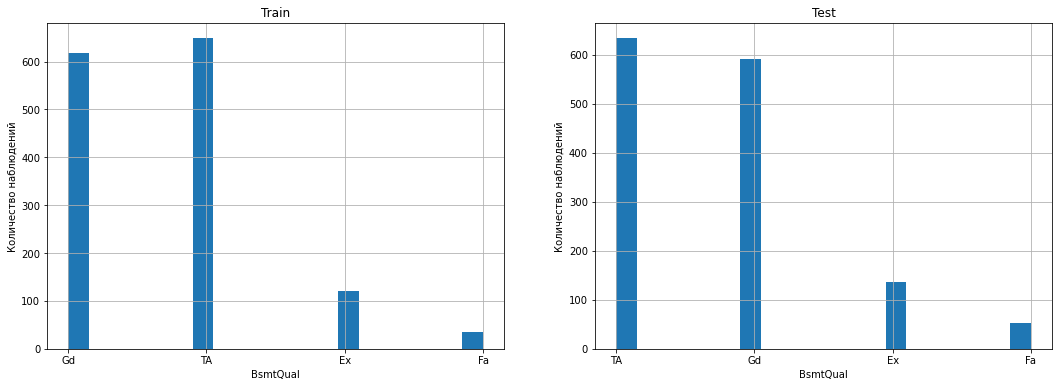

In [102]:
show_col('BsmtQual')

In [103]:
train_df["BsmtQual"] = train_df["BsmtQual"].apply(lambda x: None if x is np.nan else x)

In [104]:
all_df["BsmtQual"] = train_df["BsmtQual"].map(qual_dict).astype(int)
onehot_df = onehot(onehot_df, train_df, "BsmtQual", "None", "Ex")

##### BsmtCond
'BsmtCond' - Оценивает общее состояние подвального помещения

Количество пропущенных значений в тренировочном датасете = 37
Количество пропущенных значений в тестовом датасете = 45


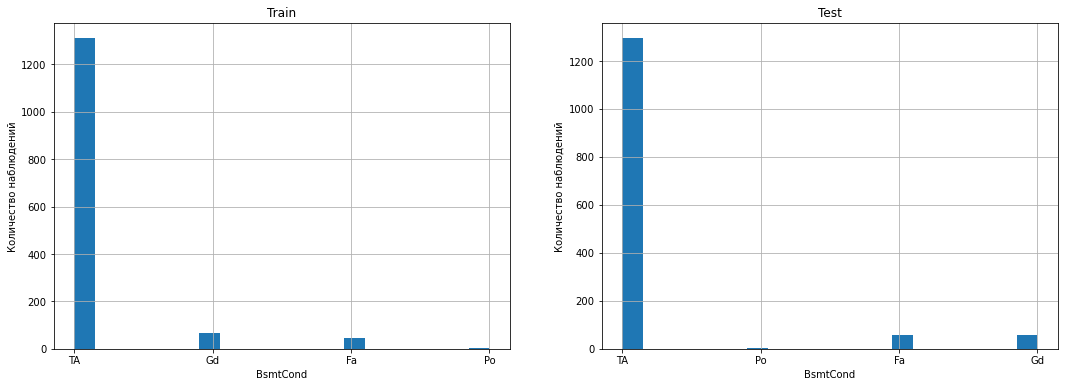

In [105]:
show_col('BsmtCond')

In [106]:
train_df["BsmtCond"] = train_df["BsmtCond"].apply(lambda x: None if x is np.nan else x)
all_df["BsmtCond"] = train_df["BsmtCond"].map(qual_dict).astype(int)
onehot_df = onehot(onehot_df, train_df, "BsmtCond", "None", "Ex")

##### BsmtExposure
'BsmtExposure' - Относится к стенам на уровне прохода или сада

Количество пропущенных значений в тренировочном датасете = 38
Количество пропущенных значений в тестовом датасете = 44


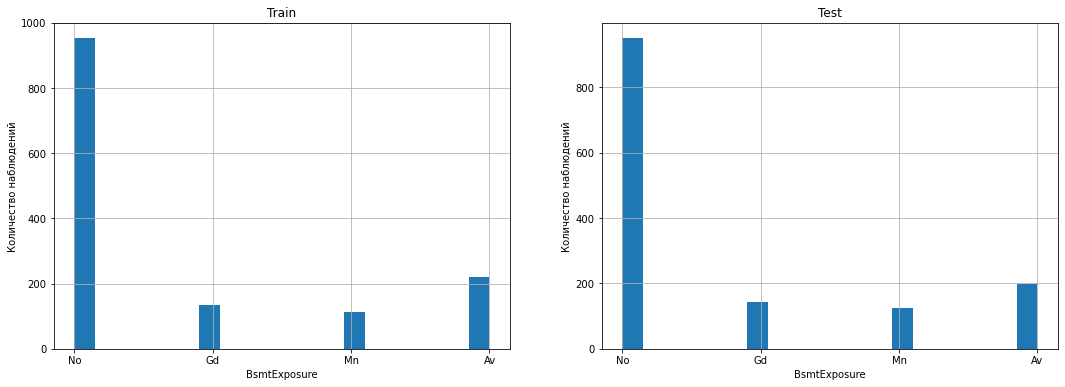

In [107]:
show_col('BsmtExposure')

In [108]:
d = {None: 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}
all_df["BsmtExposure"] = train_df["BsmtExposure"].map(d)
onehot_df = onehot(onehot_df, train_df, "BsmtExposure", "None", "Gd")

##### BsmtFinType1
'BsmtFinType1' - Оценка готовой площади подвала

Количество пропущенных значений в тренировочном датасете = 37
Количество пропущенных значений в тестовом датасете = 42


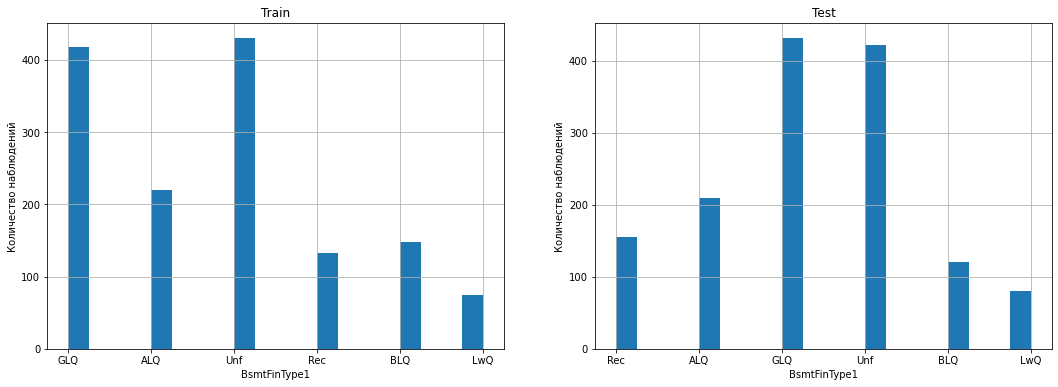

In [109]:
show_col('BsmtFinType1')

In [110]:
bsmt_fin_dict = {None: 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
all_df["BsmtFinType1"] = train_df["BsmtFinType1"].map(bsmt_fin_dict).astype(int)
onehot_df = onehot(onehot_df, train_df, "BsmtFinType1", "None", "GLQ")

##### BsmtFinSF1
'BsmtFinSF1 - Тип 1 готовые квадратные футы

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 1


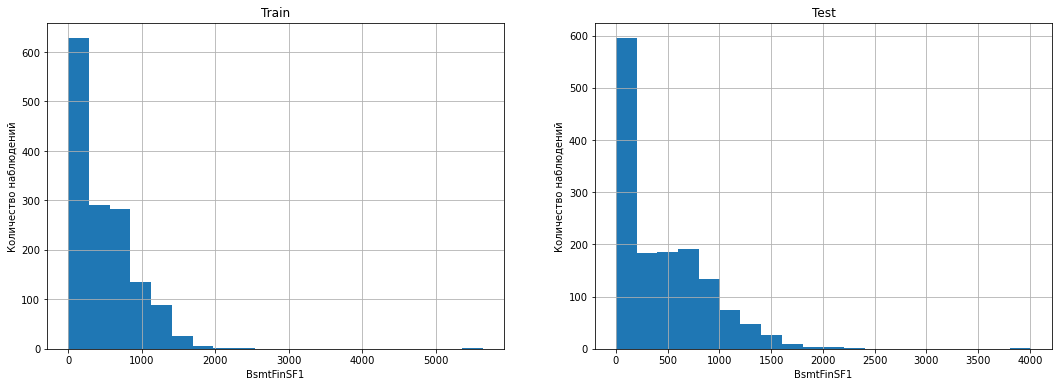

In [111]:
show_col('BsmtFinSF1')

In [112]:
all_df["BsmtFinSF1"] = train_df["BsmtFinSF1"]
all_df["BsmtFinSF1"].fillna(0, inplace=True)

##### BsmtFinType2
'BsmtFinType2' - 

Количество пропущенных значений в тренировочном датасете = 38
Количество пропущенных значений в тестовом датасете = 42


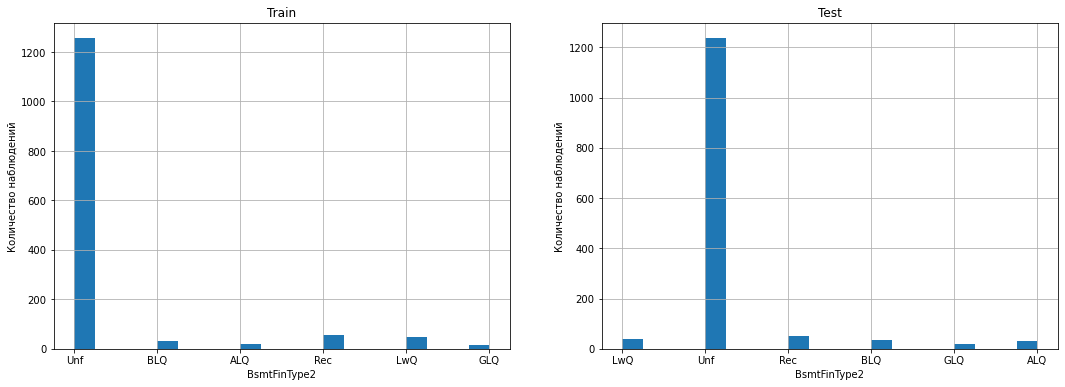

In [113]:
show_col('BsmtFinType2')

In [114]:
all_df["BsmtFinType2"] = train_df["BsmtFinType2"].map(bsmt_fin_dict).astype(int)
onehot_df = onehot(onehot_df, train_df, "BsmtFinType2", "None", "GLQ")

##### BsmtFinSF2
'BsmtFinSF2' - Тип 2 готовые квадратные метры

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 1


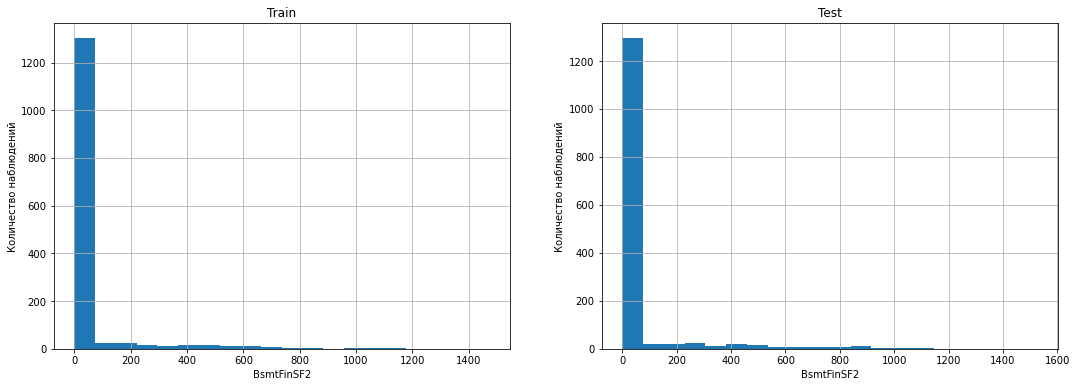

In [115]:
show_col('BsmtFinSF2')

In [116]:
all_df["BsmtFinSF2"] = train_df["BsmtFinSF2"]
all_df["BsmtFinSF2"].fillna(0, inplace=True)

##### BsmtUnfSF
'BsmtUnfSF' - Незаконченные квадратные футы площади подвала

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 1


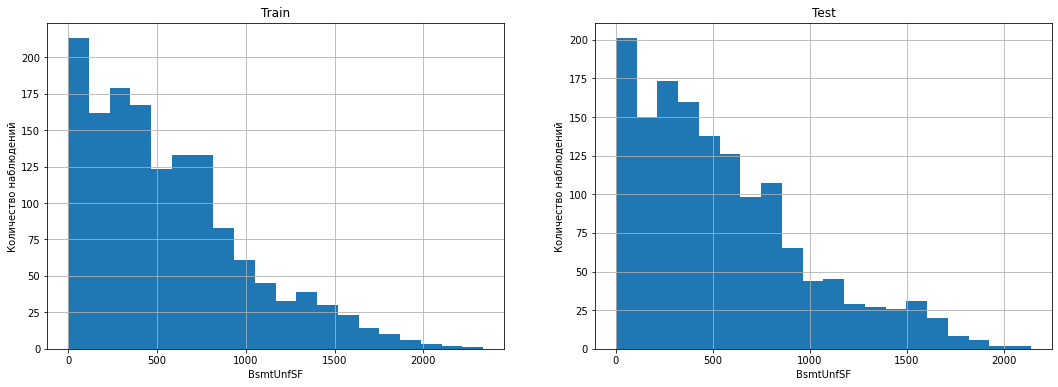

In [117]:
show_col('BsmtUnfSF')

In [118]:
all_df["BsmtUnfSF"] = train_df["BsmtUnfSF"]
all_df["BsmtUnfSF"].fillna(0, inplace=True)

##### TotalBsmtSF
'TotalBsmtSF' - Общая площадь подвального помещения в квадратных футах

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 1


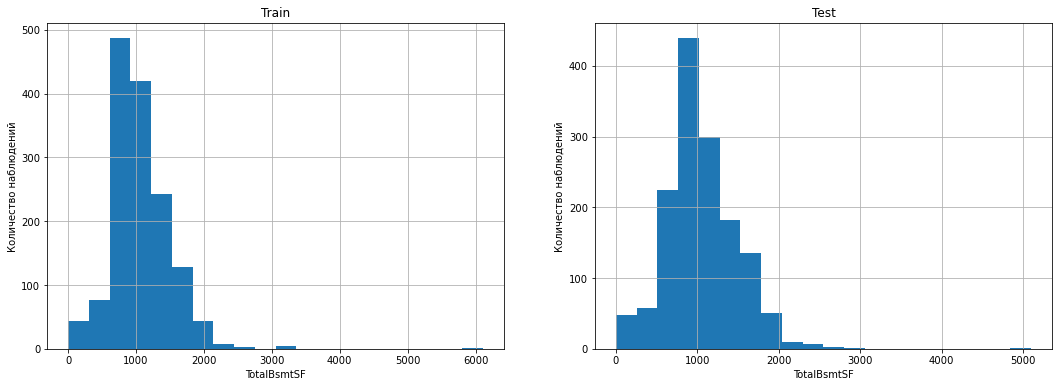

In [119]:
show_col('TotalBsmtSF')

In [120]:
all_df["BsmtUnfSF"] = train_df["BsmtUnfSF"]
all_df["BsmtUnfSF"].fillna(0, inplace=True)

##### Heating
'Heating' - Тип отопления

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


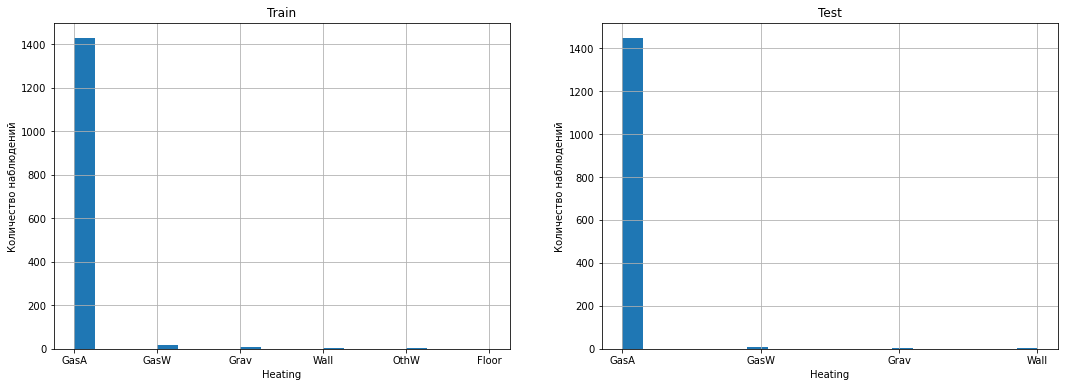

In [121]:
show_col('Heating')

In [122]:
onehot_df = onehot(onehot_df, train_df, "Heating", None, "Wall")

In [123]:
drop_cols  =  show_different_values("Heating")
drop_cols = ["_Heating_" + x for x in drop_cols]
onehot_df.drop(drop_cols, axis = 1, inplace = True)

##### HeatingQC 
'HeatingQC' - Качество и состояние отопления

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


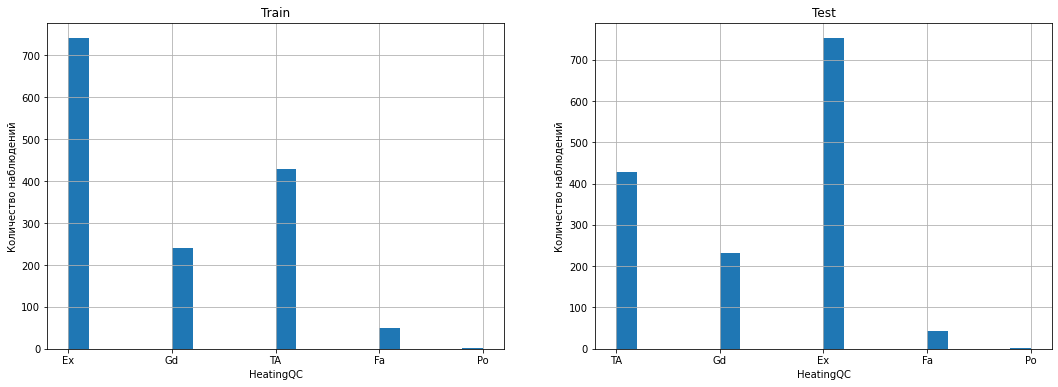

In [124]:
show_col('HeatingQC')

In [125]:
all_df["HeatingQC"] = train_df["HeatingQC"].map(qual_dict).astype(int)
onehot_df = onehot(onehot_df, train_df, "HeatingQC", "None", "Ex")

##### CentralAir
'CentralAir' - Центральное кондиционирование воздуха

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


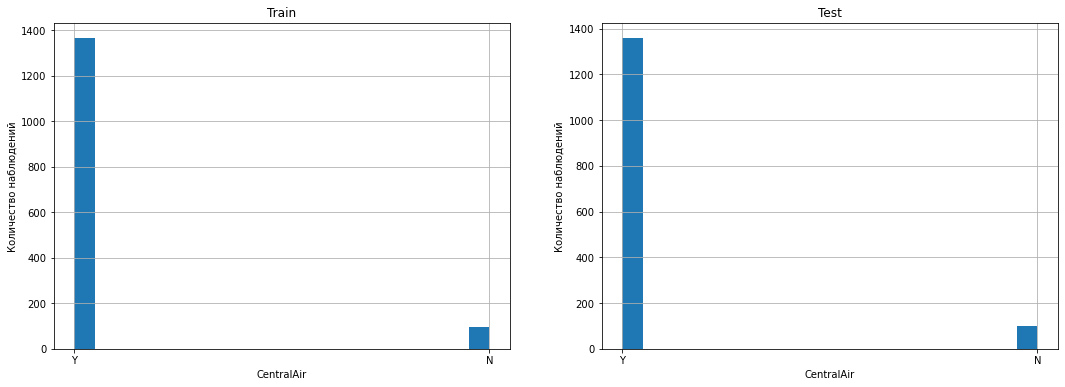

In [126]:
show_col('CentralAir')

In [127]:
all_df["CentralAir"] = (train_df["CentralAir"] == "Y").apply(int)

##### Electrical
Electrical - Электрическая система

Количество пропущенных значений в тренировочном датасете = 1
Количество пропущенных значений в тестовом датасете = 0


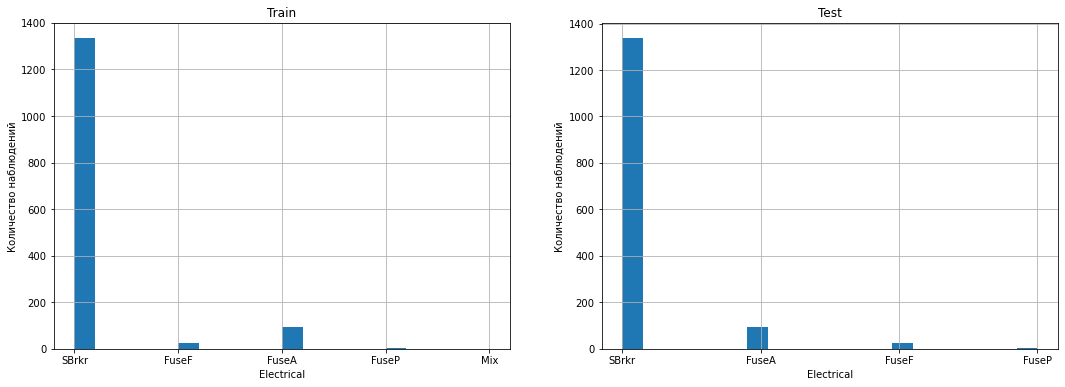

In [128]:
show_col('Electrical')

In [129]:
onehot_df = onehot(onehot_df, train_df, "Electrical", "SBrkr", "FuseP")

In [130]:
show_different_values("Electrical")

[None, 'Mix']

In [131]:
onehot_df.drop('_Electrical_Mix', axis = 1, inplace = True)

##### 1stFlrSF
'1stFlrSF' - Площадь первого этажа (футы в квадратах)

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


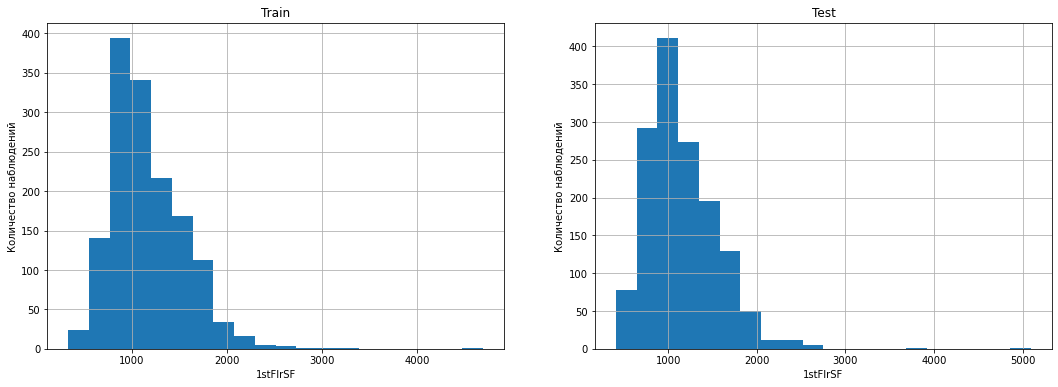

In [132]:
show_col('1stFlrSF')

In [133]:
all_df["1stFlrSF"] = train_df["1stFlrSF"]

##### 2ndFlrSF
'2ndFlrSF' - Площадь второго этажа (футы в квадратах)

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


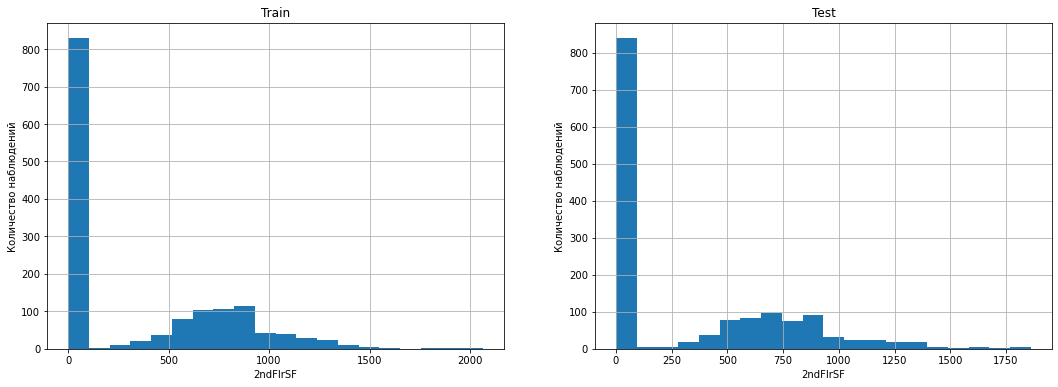

In [134]:
show_col('2ndFlrSF')

In [135]:
all_df["2ndFlrSF"] = train_df["2ndFlrSF"]

In [136]:
all_df["Has2ndFloor"] = (all_df["2ndFlrSF"] == 0) * 1

##### LowQualFinSF
'LowQualFinSF' - Низкое качество готовых квадратных футов (все этажи).

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


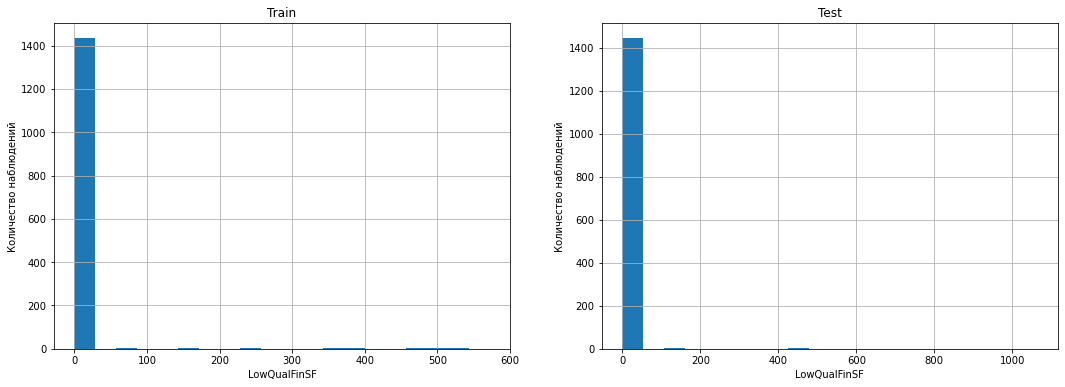

In [137]:
show_col('LowQualFinSF')

In [138]:
all_df["LowQualFinSF"] = train_df["LowQualFinSF"]

##### GrLivArea
'GrLivArea' - Жилая площадь над уровнем земли (на земле) (квадратные футы)

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


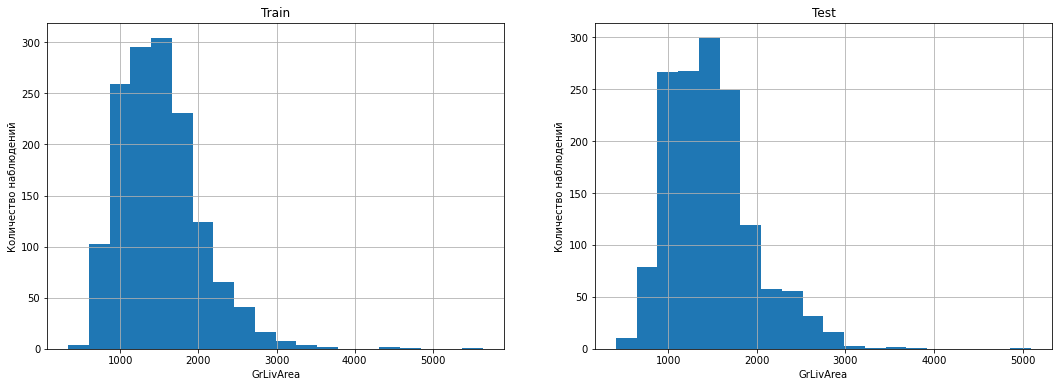

In [139]:
show_col('GrLivArea')

In [140]:
write_outlires_inf("'GrLivArea' > 4000")

In [141]:
all_df["GrLivArea"] = train_df["GrLivArea"]

##### BsmtFullBath
'BsmtFullBath' -  Полные ванные комнаты в подвале

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 2


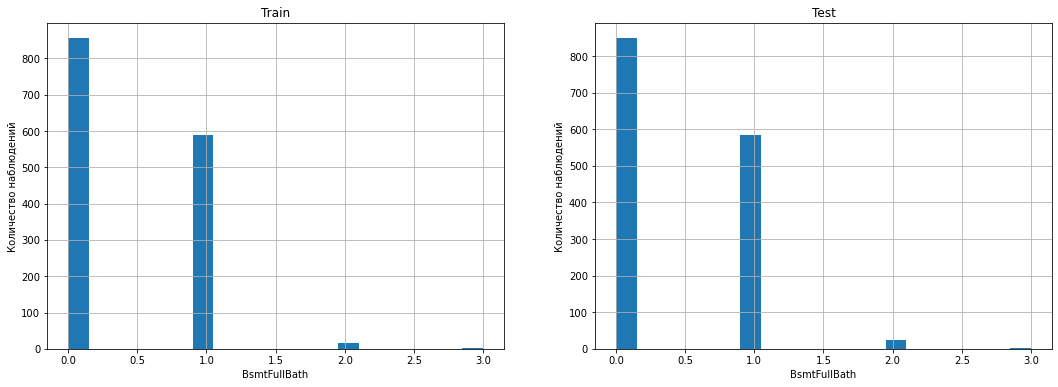

In [142]:
show_col('BsmtFullBath')

In [143]:
all_df["BsmtFullBath"] = train_df["BsmtFullBath"].fillna(0)

##### BsmtHalfBath
'BsmtHalfBath' - Половина ванных комнат в подвале 

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 2


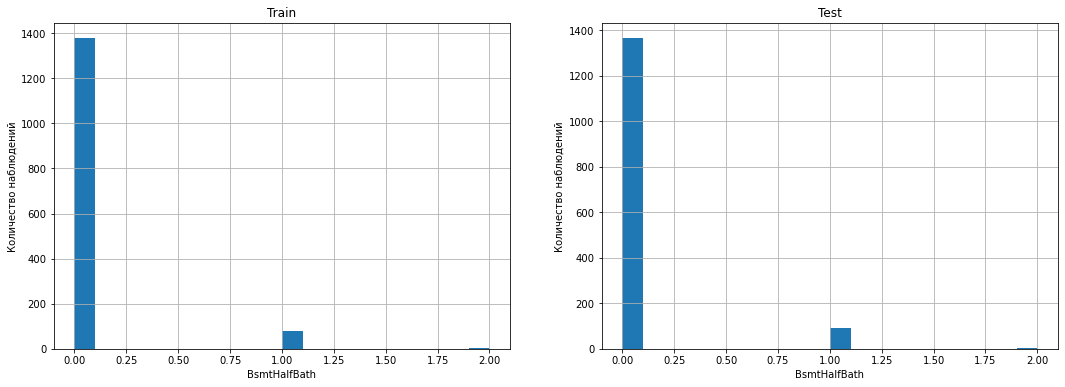

In [144]:
show_col('BsmtHalfBath')

In [145]:
all_df["BsmtHalfBath"] = train_df["BsmtHalfBath"].fillna(0)

##### FullBath
'FullBath' - Полные ванные комнаты над уровнем земли

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


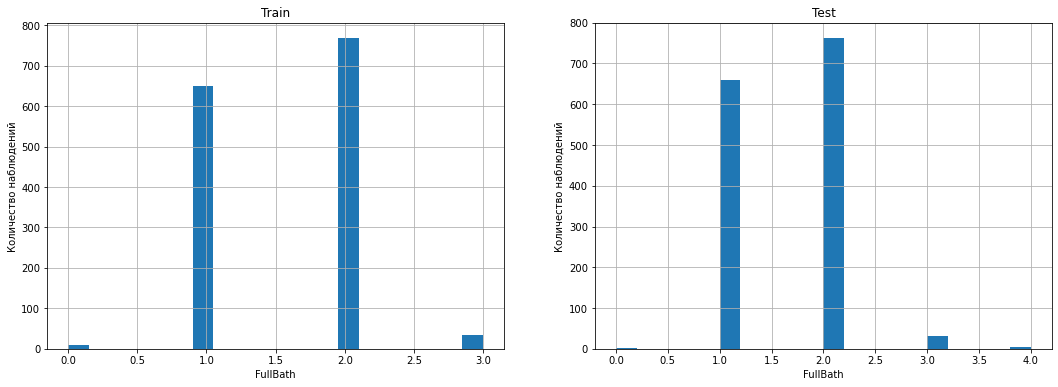

In [146]:
show_col('FullBath')

In [147]:
all_df["FullBath"] = train_df["FullBath"] 

##### HalfBath
'HalfBath' - Полуванны над уровнем земли

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


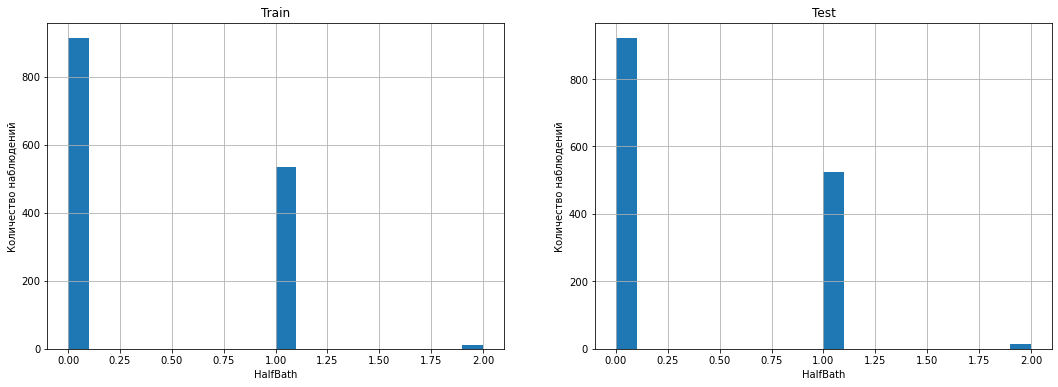

In [148]:
show_col('HalfBath')

In [149]:
all_df["HalfBath"] = train_df["HalfBath"] 

##### BedroomAbvGr
'BedroomAbvGr' - Спальни над уровнем земли (не включает спальни в подвале)

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


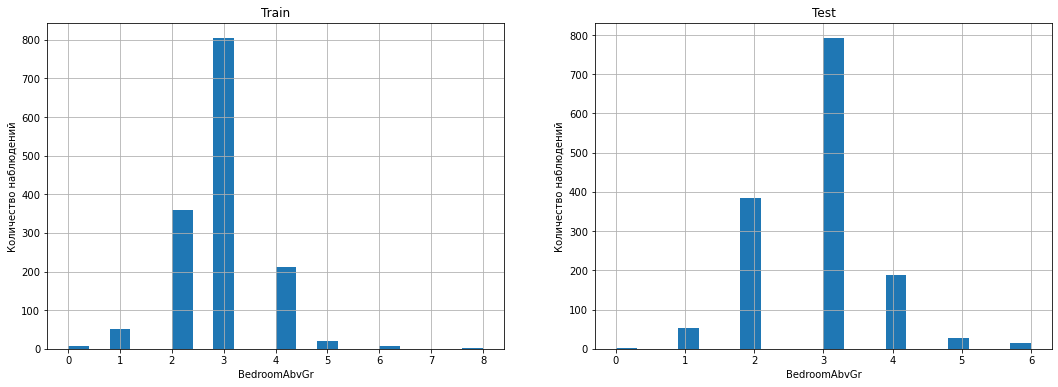

In [150]:
show_col('BedroomAbvGr')

In [151]:
all_df["BedroomAbvGr"] = train_df["BedroomAbvGr"] 

##### KitchenAbvGr
'KitchenAbvGr' - Кухни над уровнем земли

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


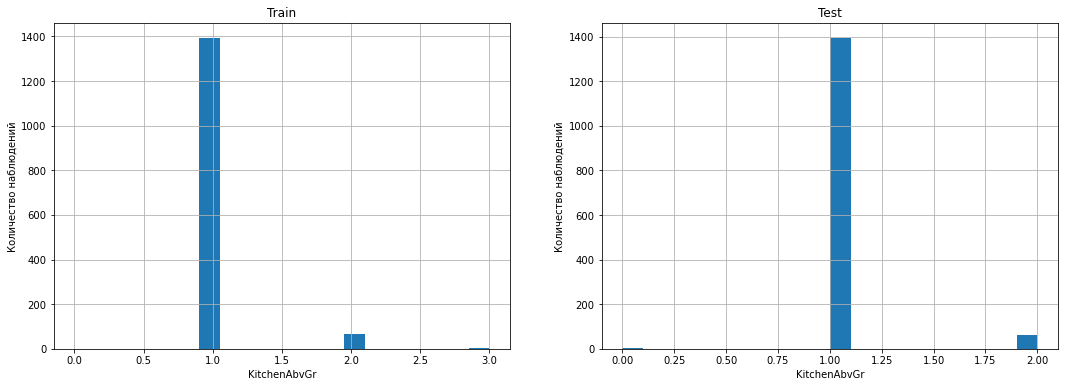

In [152]:
show_col('KitchenAbvGr')

In [153]:
all_df["KitchenAbvGr"] = train_df["KitchenAbvGr"] 

##### KitchenQual
'KitchenQual' - Качество кухни

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 1


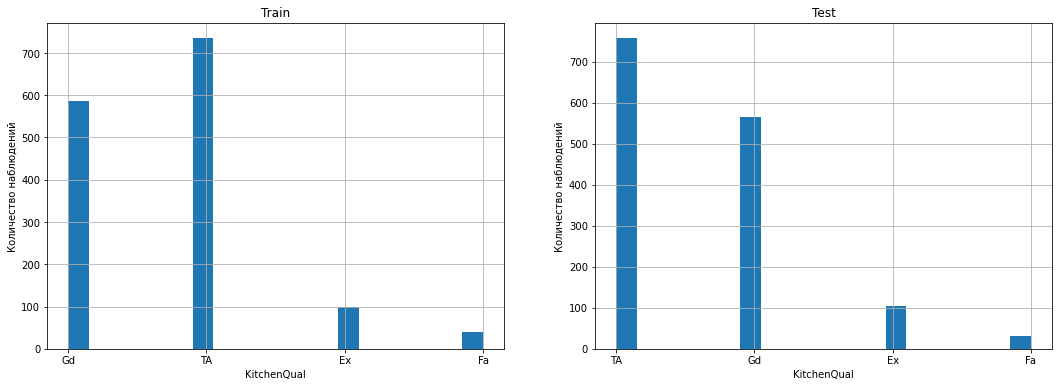

In [154]:
show_col('KitchenQual')

In [155]:
all_df["KitchenQual"] = train_df["KitchenQual"].map(qual_dict).astype(int)
onehot_df = onehot(onehot_df, train_df, "KitchenQual", "TA", "Ex")

##### TotRmsAbvGrd
'TotRmsAbvGrd' - Общее количество помещений над уровнем земли (не включая ванные комнаты)

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


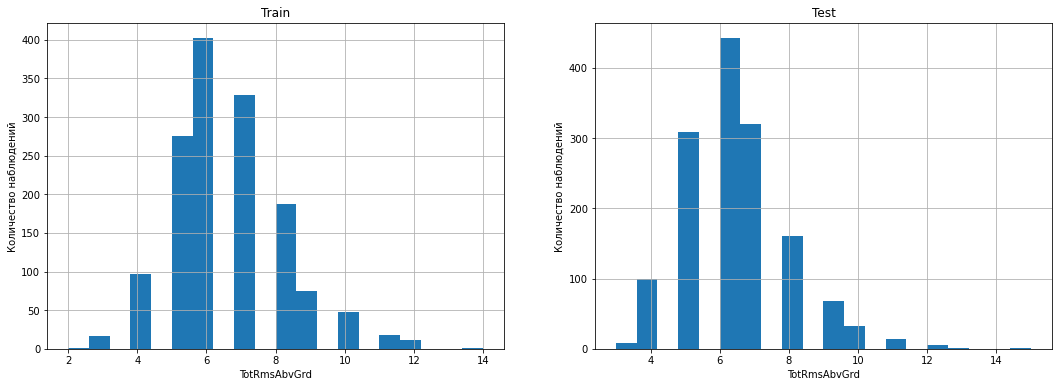

In [156]:
show_col('TotRmsAbvGrd')

In [157]:
all_df["TotRmsAbvGrd"] = train_df["TotRmsAbvGrd"]

##### TotRmsAbvGrd
'TotRmsAbvGrd' - Общее количество помещений над уровнем земли (не включая ванные комнаты)

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


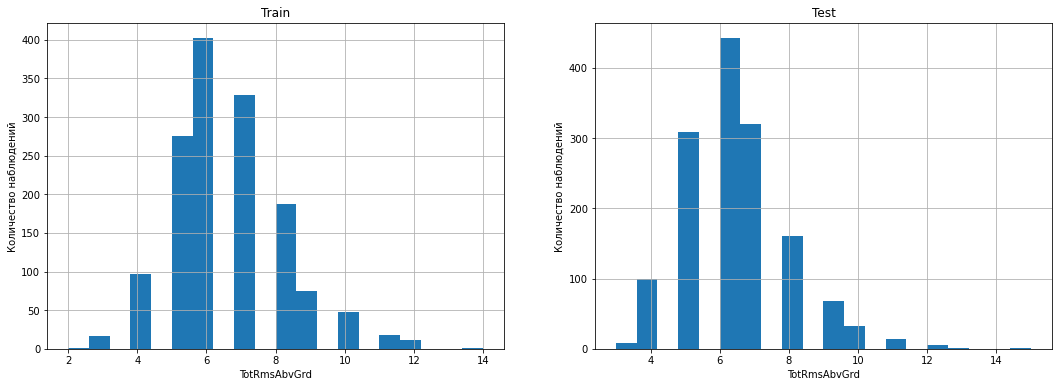

In [158]:
show_col('TotRmsAbvGrd')

In [159]:
all_df["TotRmsAbvGrd"] = train_df["TotRmsAbvGrd"]

##### Functional
'Functional' - Функциональность дома (предполагается типичной, если вычеты не оправданы)

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 2


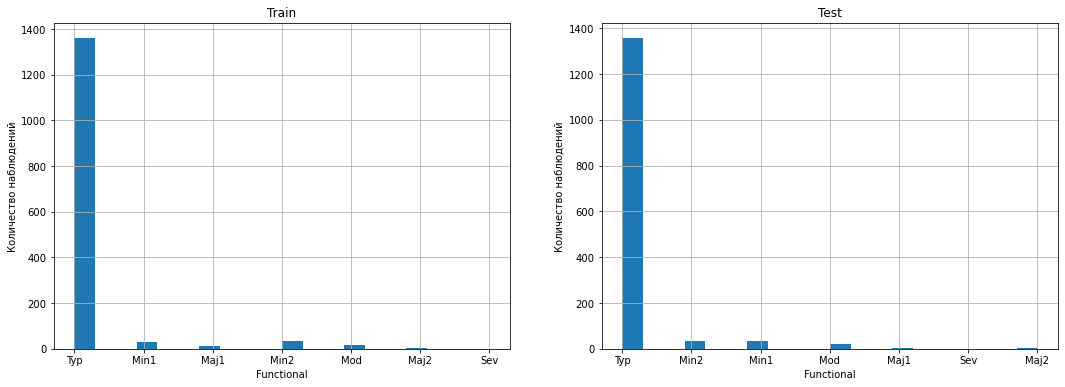

In [160]:
show_col('Functional')

In [161]:
all_df["Functional"] = train_df["Functional"].map(
        {None: 0, "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, 
         "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8}).astype(int)

onehot_df = onehot(onehot_df, train_df, "Functional", "Typ", "Typ")

##### Fireplaces
'Fireplaces' - Количество каминов

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


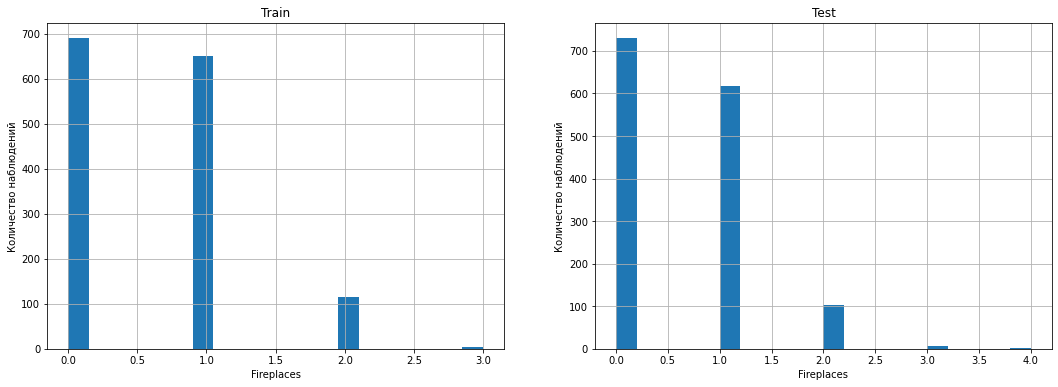

In [162]:
show_col('Fireplaces')

In [163]:
all_df["Fireplaces"] = train_df["Fireplaces"] 

##### FireplaceQu
'FireplaceQu' - Качество камина

Количество пропущенных значений в тренировочном датасете = 690
Количество пропущенных значений в тестовом датасете = 730


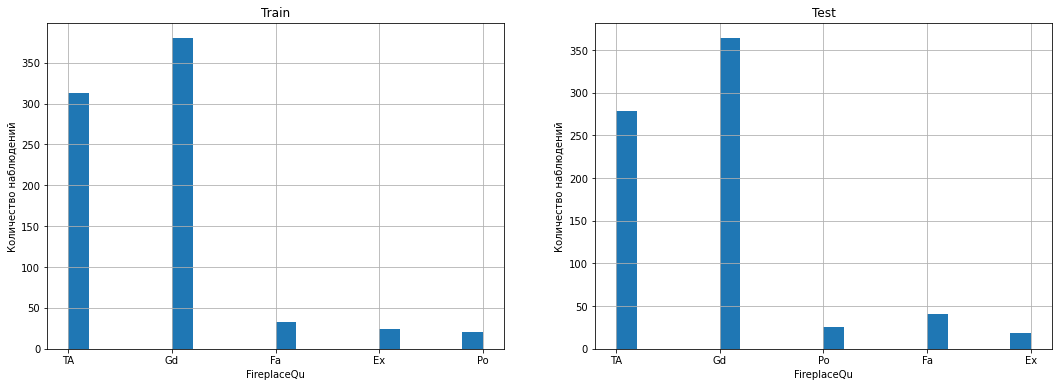

In [164]:
show_col('FireplaceQu')

In [165]:
all_df["FireplaceQu"] = train_df["FireplaceQu"].map(qual_dict).astype(int)
onehot_df = onehot(onehot_df, train_df, "FireplaceQu", "None", "Ex")

##### GarageType
'GarageType' - Расположение гаража

Количество пропущенных значений в тренировочном датасете = 81
Количество пропущенных значений в тестовом датасете = 76


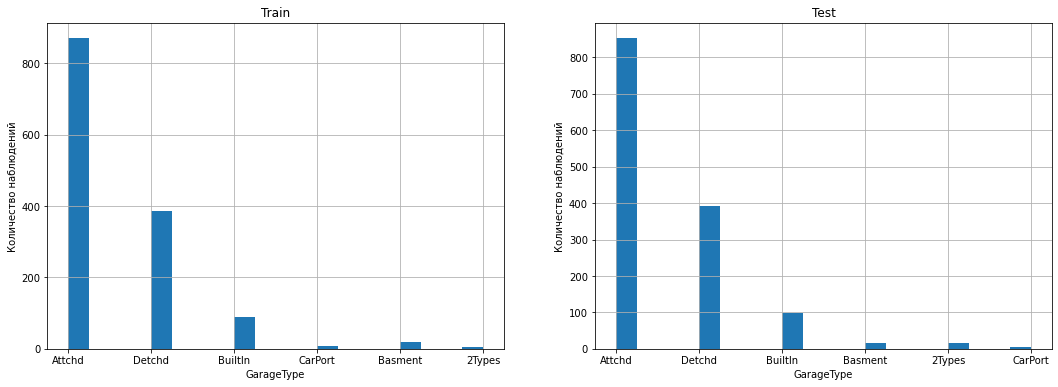

In [166]:
show_col('GarageType')

In [167]:
onehot_df = onehot(onehot_df, train_df, "GarageType", "None", "CarPort")

##### GarageYrBlt
'GarageYrBlt' - Год постройки гаража

Количество пропущенных значений в тренировочном датасете = 81
Количество пропущенных значений в тестовом датасете = 78


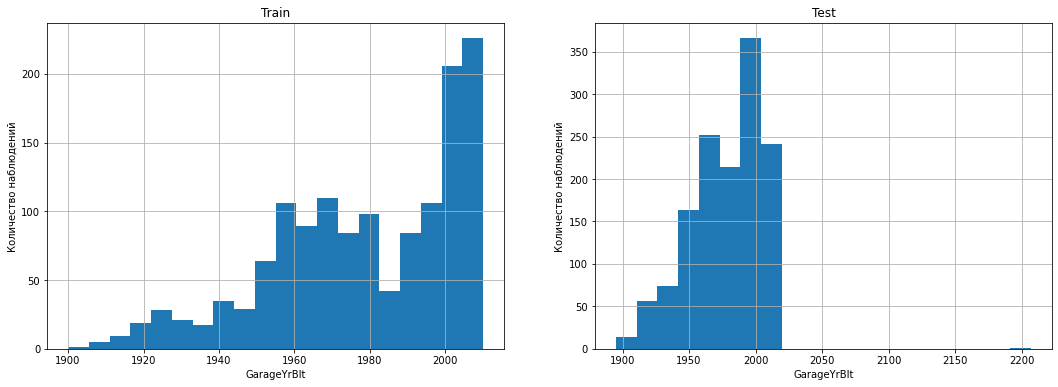

In [168]:
show_col('GarageYrBlt')

In [169]:
test_df[test_df['GarageYrBlt'] > 2150]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
2593,20,RL,68.0,8298,Pave,NaN,IR1,HLS,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2007,New,Partial


Заполним некоректное значение годом постройки

In [170]:
test_df.loc[2593, 'GarageYrBlt'] = test_df.loc[2593, 'YearBuilt']

Количество пропущенных значений в тренировочном датасете = 81
Количество пропущенных значений в тестовом датасете = 78


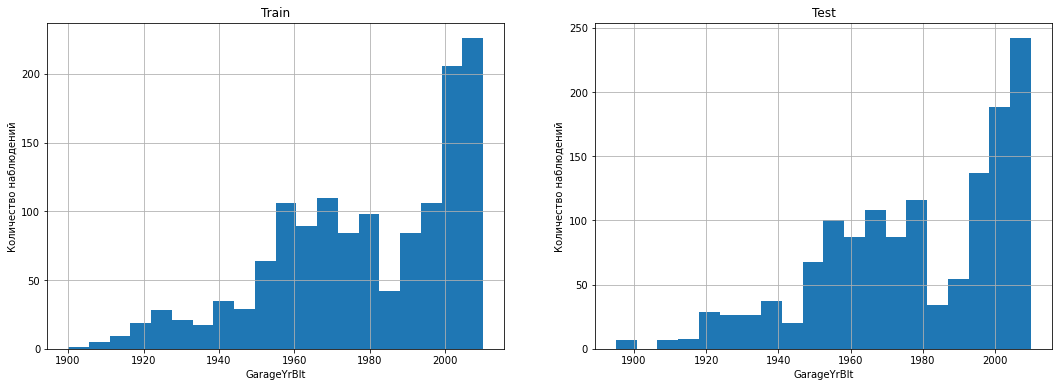

In [171]:
show_col('GarageYrBlt')

In [172]:
all_df["GarageYrBlt"] = train_df["GarageYrBlt"].fillna(0.0)

In [173]:
# Разобъём года на сегменты по 20 лет каждый
year_map = pd.concat(pd.Series("YearBin" + str(i+1), index=range(1871+i*20,1891+i*20)) for i in range(0, 7))

yearbin_df = pd.DataFrame(index = train_df.index)
yearbin_df["GarageYrBltBin"] = train_df.GarageYrBlt.map(year_map)
yearbin_df["GarageYrBltBin"].fillna("NoGarage", inplace=True)

In [174]:
onehot_df = onehot(onehot_df, yearbin_df, "GarageYrBltBin", None, None)

##### GarageFinish
'GarageFinish' - Внутренняя отделка гаража

Количество пропущенных значений в тренировочном датасете = 81
Количество пропущенных значений в тестовом датасете = 78


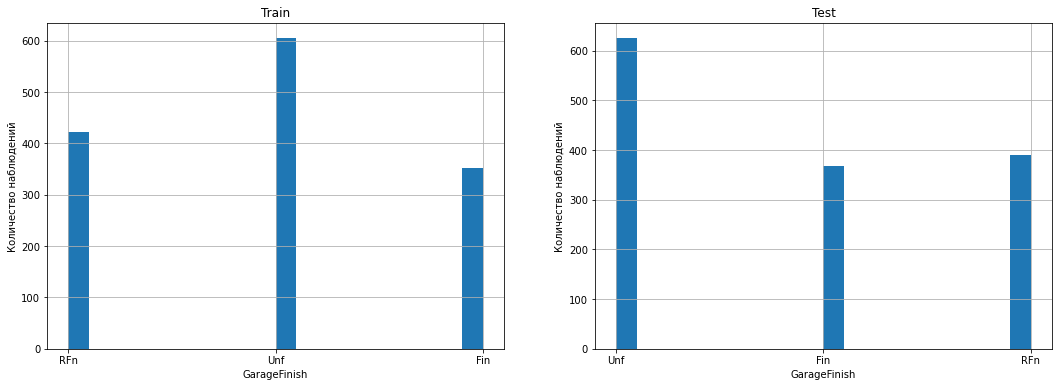

In [175]:
show_col('GarageFinish')

In [176]:
all_df["GarageFinish"] = train_df["GarageFinish"].map(
        {None: 0, "Unf": 1, "RFn": 2, "Fin": 3}).astype(int)

onehot_df = onehot(onehot_df, train_df, "GarageFinish", "None", "Fin")

##### GarageCars
'GarageCars' - Размер гаража в машино-местах

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 1


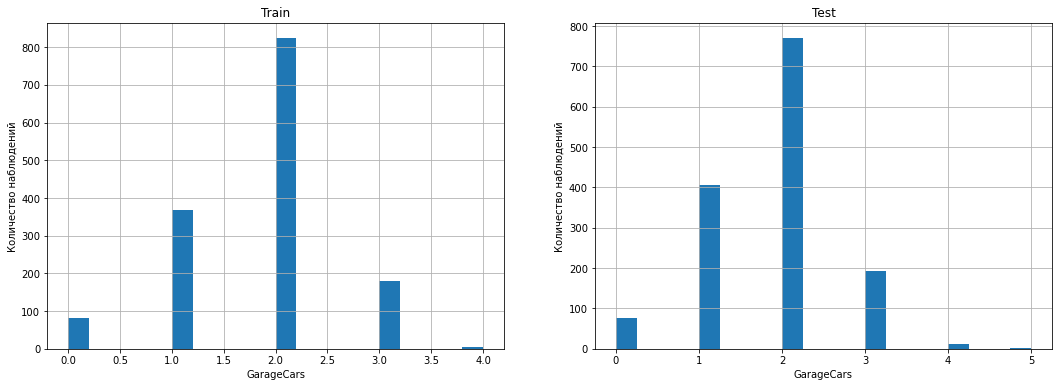

In [177]:
show_col('GarageCars')

In [178]:
all_df["GarageCars"] = train_df["GarageCars"].fillna(0)

##### GarageArea
'GarageArea' - Размер гаража в квадратных футах

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 1


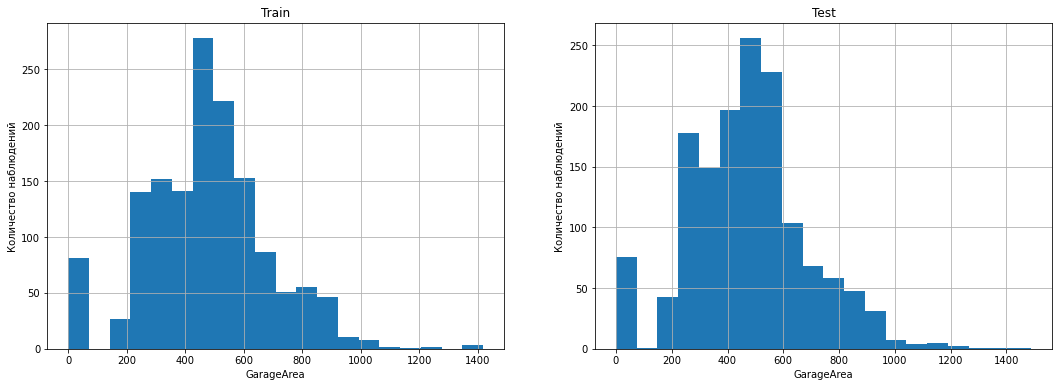

In [179]:
show_col('GarageArea')

In [180]:
all_df["GarageArea"] = train_df["GarageArea"].fillna(0)

##### GarageQual
'GarageQual' - Качество гаража

Количество пропущенных значений в тренировочном датасете = 81
Количество пропущенных значений в тестовом датасете = 78


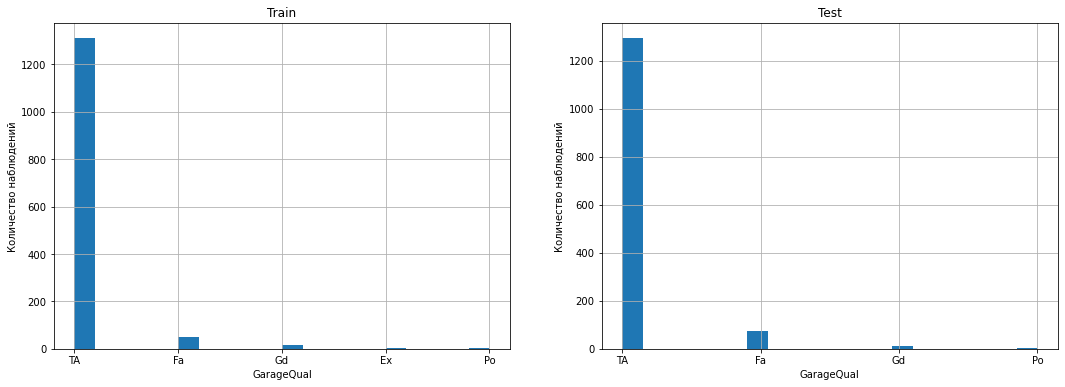

In [181]:
show_col('GarageQual')

In [182]:
all_df["GarageQual"] = train_df["GarageQual"].map(qual_dict).astype(int)
onehot_df = onehot(onehot_df, train_df, "GarageQual", "None", "Ex")

In [183]:
onehot_df.drop("_GarageQual_Ex", axis = 1, inplace = True)

##### GarageCond
GarageCond - Состояние гаража

Количество пропущенных значений в тренировочном датасете = 81
Количество пропущенных значений в тестовом датасете = 78


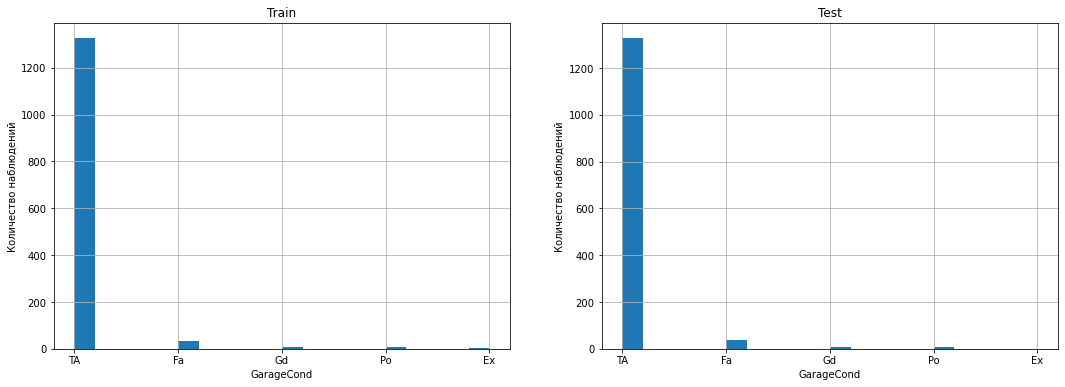

In [184]:
show_col('GarageCond')

In [185]:
all_df["GarageCond"] = train_df["GarageCond"].map(qual_dict).astype(int)
onehot_df = onehot(onehot_df, train_df, "GarageCond", "None", "Ex")

##### PavedDrive
'PavedDrive' - Проложенная подъездная дорога

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


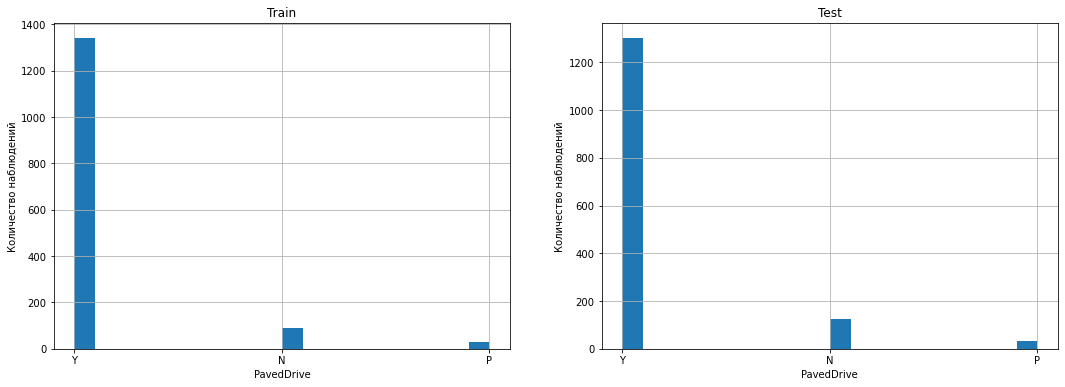

In [186]:
show_col('PavedDrive')

In [187]:
onehot_df = onehot(onehot_df, train_df, "PavedDrive", None, "P")

##### WoodDeckSF
'WoodDeckSF' - Площадь деревянного настила в квадратных футах

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


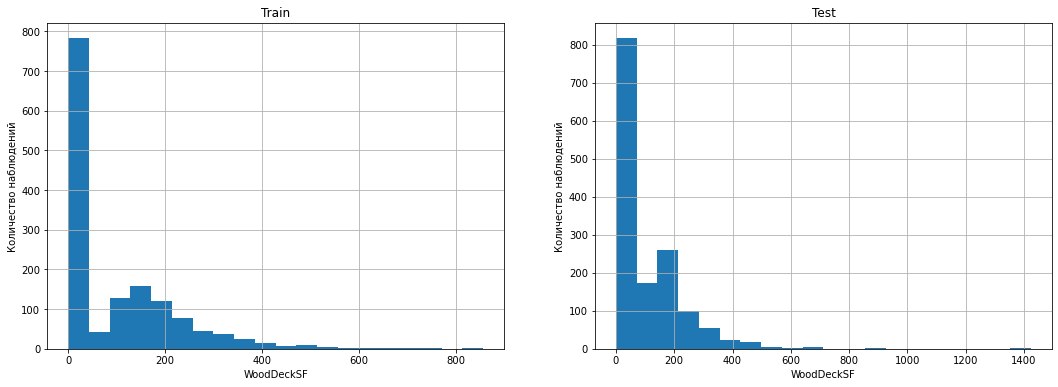

In [188]:
show_col('WoodDeckSF')

In [189]:
all_df["WoodDeckSF"] = train_df["WoodDeckSF"]
all_df["HasWoodDeck"] = (all_df["WoodDeckSF"] == 0) * 1

##### OpenPorchSF
'OpenPorchSF' - Площадь открытого крыльца в квадратных футах

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


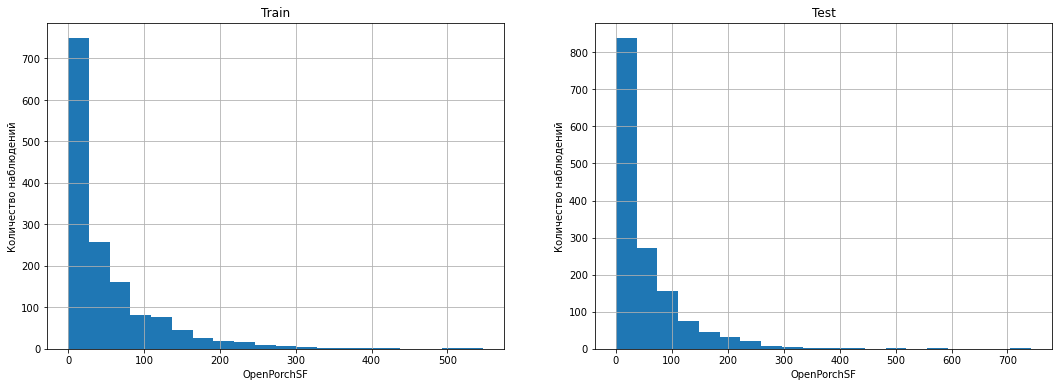

In [190]:
show_col('OpenPorchSF')

Логичен бинарный признак о наличии крыльца

In [191]:
all_df["OpenPorchSF"] = train_df["OpenPorchSF"]
all_df["HasOpenPorch"] = (all_df["OpenPorchSF"] == 0) * 1

##### EnclosedPorch
'EnclosedPorch' - Площадь закрытого крыльца в квадратных футах

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


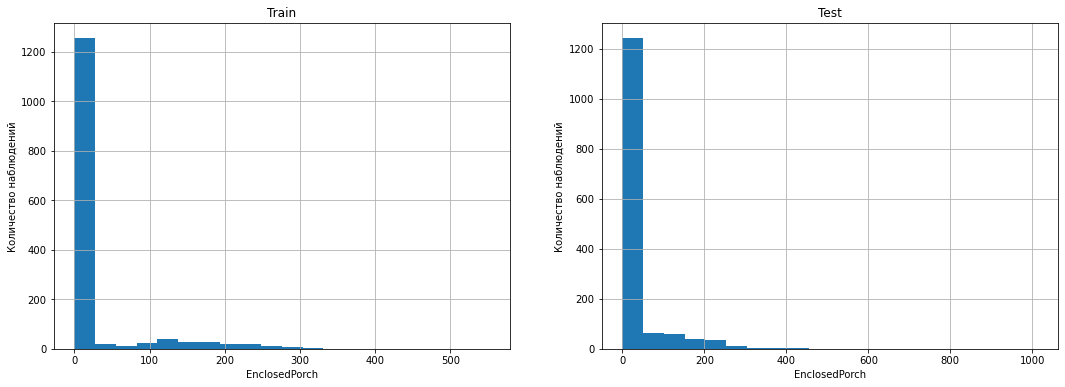

In [192]:
show_col('EnclosedPorch')

In [193]:
all_df["EnclosedPorch"] = train_df["EnclosedPorch"]
all_df["HasEnclosedPorch"] = (all_df["EnclosedPorch"] == 0) * 1

##### 3SsnPorch
'3SsnPorch' - Площадь трехсезонного крыльца в квадратных футах

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


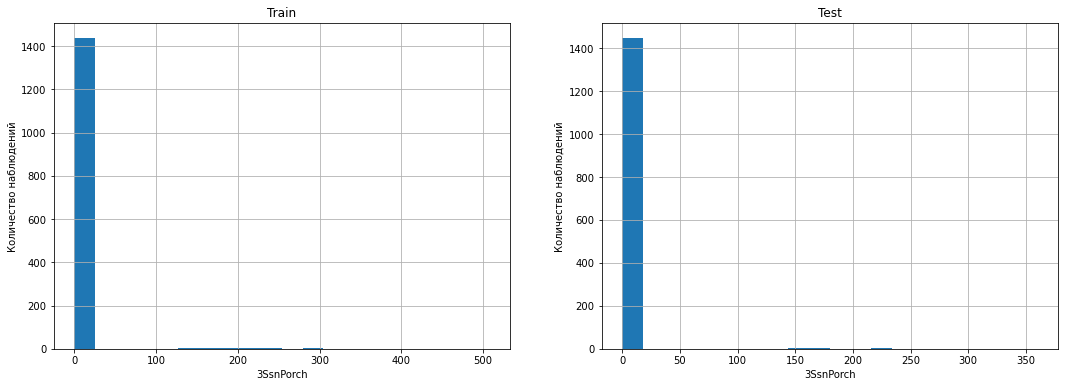

In [194]:
show_col('3SsnPorch')

In [195]:
all_df["3SsnPorch"] = train_df["3SsnPorch"]
all_df["Has3SsnPorch"] = (all_df["3SsnPorch"] == 0) * 1

##### ScreenPorch
'ScreenPorch' - Площадь крыльца в квадратных футах

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


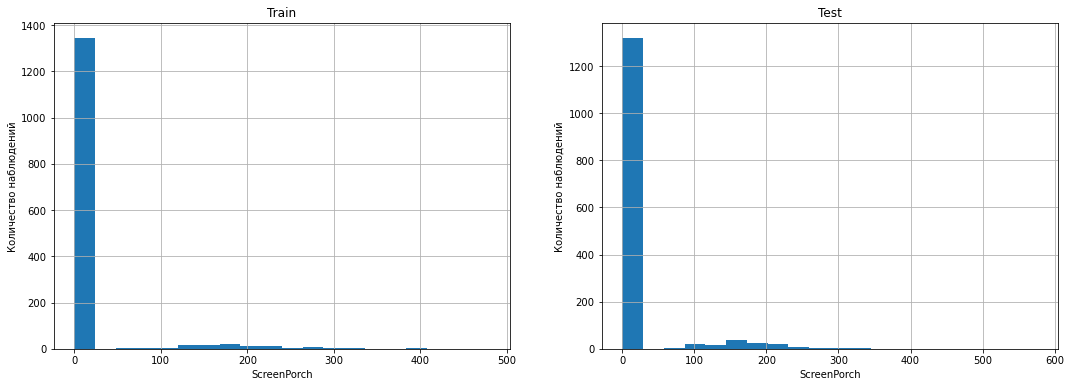

In [196]:
show_col('ScreenPorch')

In [197]:
all_df["ScreenPorch"] = train_df["ScreenPorch"]
all_df["HasScreenPorch"] = (all_df["ScreenPorch"] == 0) * 1

##### PoolArea
'PoolArea' - Площадь бассейна в квадратных футах

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


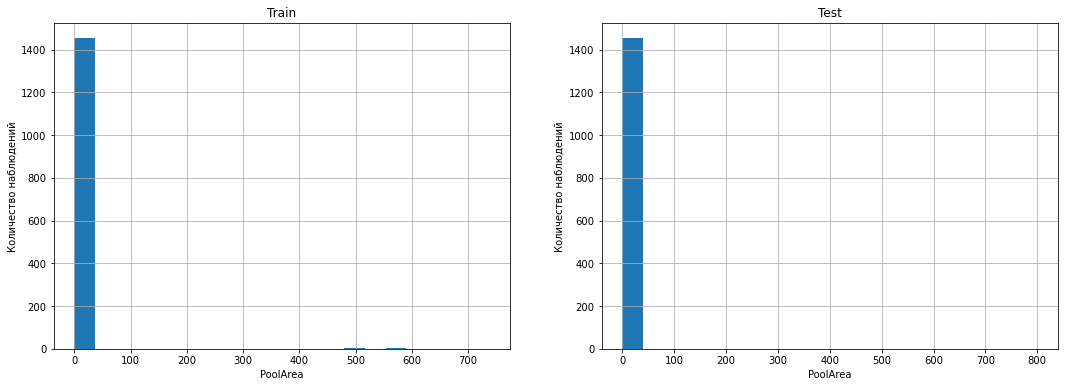

In [198]:
show_col('PoolArea')

Только бинарный признак

In [199]:
all_df["PoolArea"] = train_df["PoolArea"].fillna(0)

##### PoolQC
'PoolQC' - Качество бассейна

Количество пропущенных значений в тренировочном датасете = 1453
Количество пропущенных значений в тестовом датасете = 1456


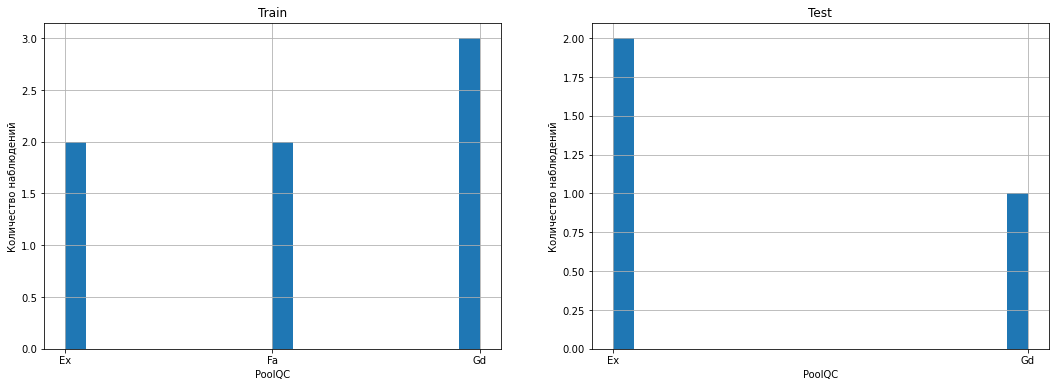

In [200]:
show_col('PoolQC')

Пропущенных значений больше чем существуюущих

In [201]:
all_df["PoolQC"] = train_df["PoolQC"].map(qual_dict).astype(int)
onehot_df = onehot(onehot_df, train_df, "PoolQC", "None", "Ex")
onehot_df.drop("_PoolQC_Fa", axis = 1, inplace = True)

##### Fence
'Fence' - 

Количество пропущенных значений в тренировочном датасете = 1179
Количество пропущенных значений в тестовом датасете = 1169


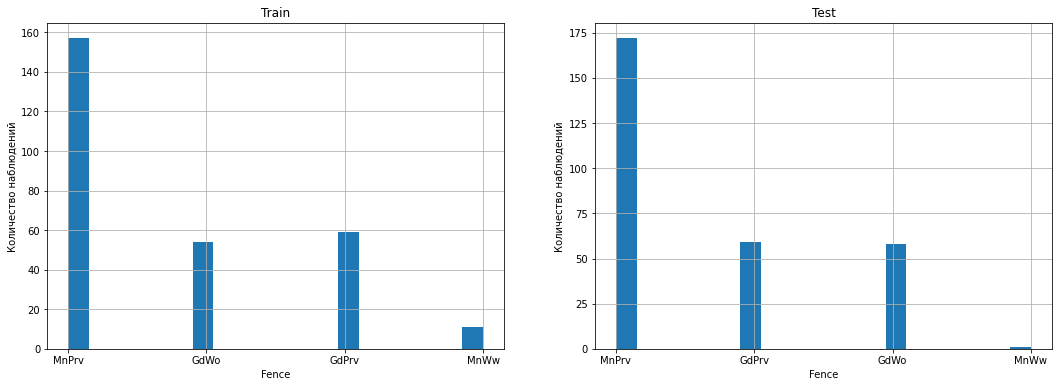

In [202]:
show_col('Fence')

In [203]:
all_df["Fence"] = train_df["Fence"].map(
        {None: 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}).astype(int)
onehot_df = onehot(onehot_df, train_df, "Fence", "None", "MnPrv")

##### MiscFeature
'MiscFeature' - Различные функции, не включенные в другие категории

Количество пропущенных значений в тренировочном датасете = 1406
Количество пропущенных значений в тестовом датасете = 1408


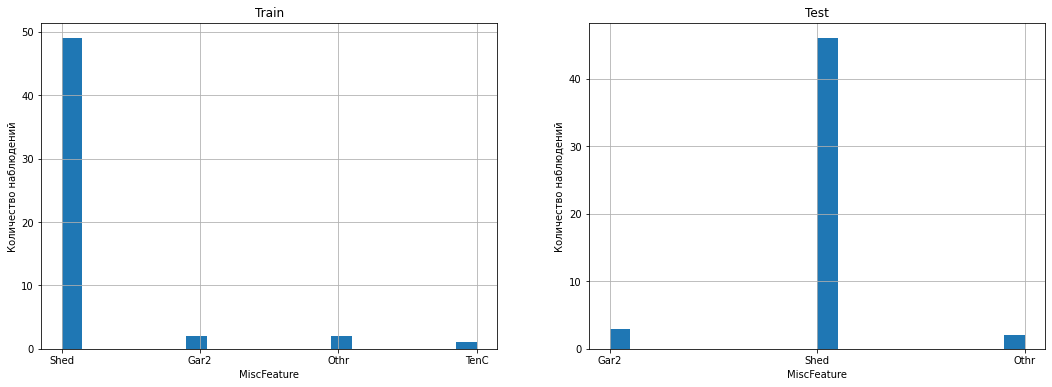

In [204]:
show_col('MiscFeature')

In [205]:
all_df["HasShed"] = (train_df["MiscFeature"] == "Shed") * 1. 
onehot_df = onehot(onehot_df, train_df, "MiscFeature", "None", "Othr")
onehot_df.drop("_MiscFeature_TenC", axis = 1, inplace = True)

##### MiscVal
'MiscVal' - Стоимость разного рода функций

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


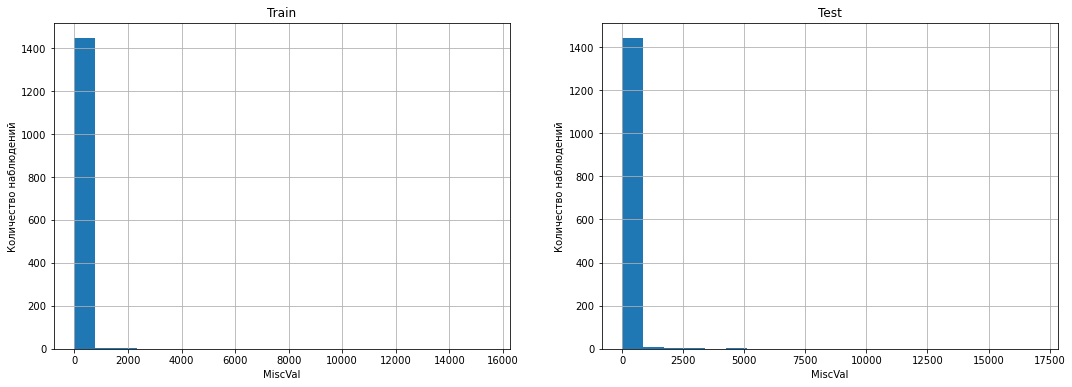

In [206]:
show_col('MiscVal')

In [207]:
all_df["MiscVal"] = train_df["MiscVal"]
all_df["HasMiscVal"] = (all_df["MiscVal"] == 0) * 1

##### MoSold
'MoSold' - Месяц продажи (ММ)

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


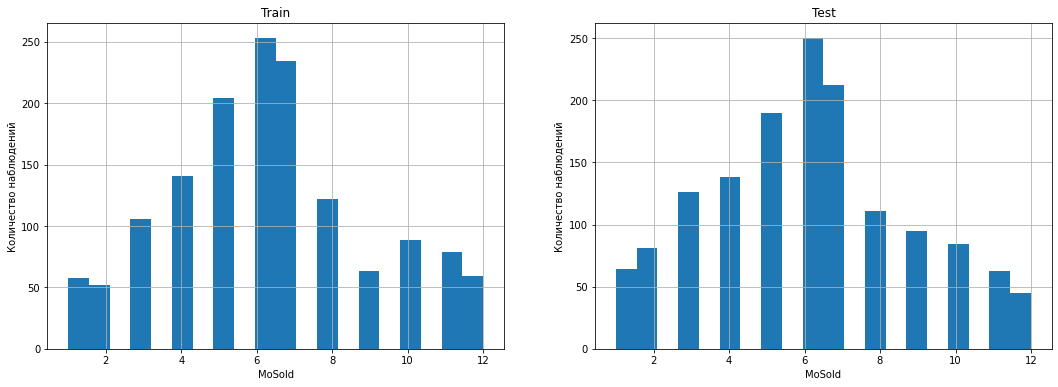

In [208]:
show_col('MoSold')

In [209]:
all_df["MoSold"] = train_df["MoSold"]
all_df["HighSeason"] = train_df["MoSold"].replace( 
        {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})
all_df["SeasonSold"] = all_df["MoSold"].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 
                                                  6:2, 7:2, 8:2, 9:3, 10:3, 11:3}).astype(int)

##### YrSold
'YrSold' - Год продажи (ГГГГ)

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


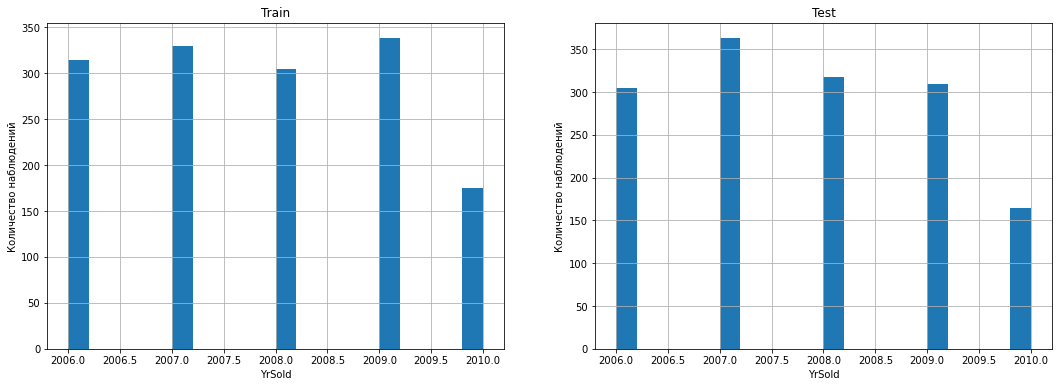

In [210]:
show_col('YrSold')

In [211]:
all_df["YrSold"] = train_df["YrSold"]

##### SaleType
'SaleType' - Тип продажи

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 1


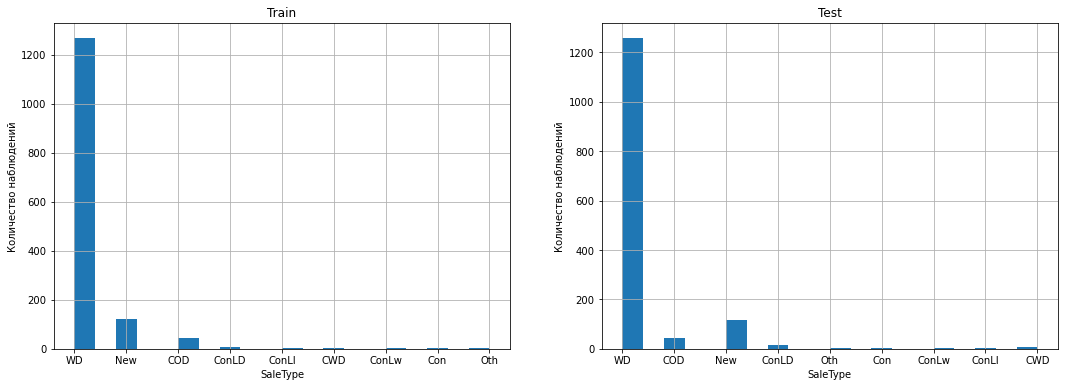

In [212]:
show_col('SaleType')

In [213]:
all_df = factorize(train_df, all_df, "SaleType", "Oth")
onehot_df = onehot(onehot_df, train_df, "SaleType", "WD", "Oth")

##### SaleCondition
'SaleCondition' - Условие продажи

Количество пропущенных значений в тренировочном датасете = 0
Количество пропущенных значений в тестовом датасете = 0


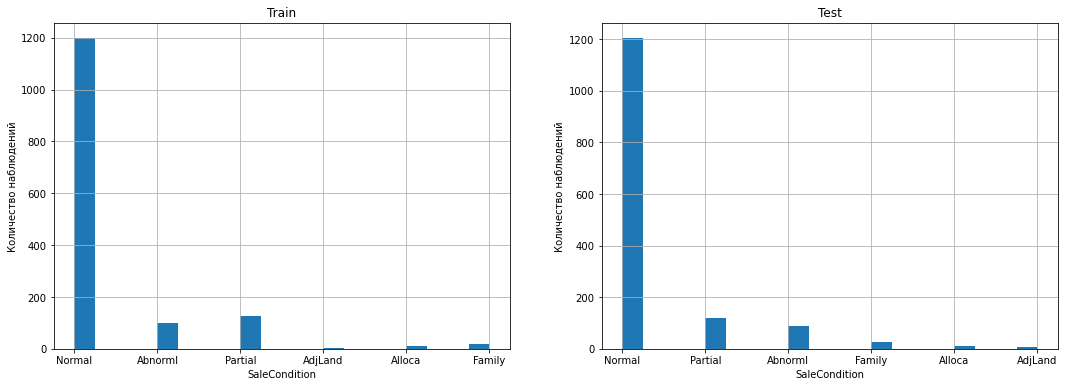

In [214]:
show_col('SaleCondition')

In [215]:
all_df = factorize(train_df, all_df, "SaleCondition")
onehot_df = onehot(onehot_df, train_df, "SaleCondition", "Normal", "AdjLand")

#### Обучим базовую модель

In [216]:
import xgboost as xgb

In [217]:
all_df.shape

(1460, 79)

In [218]:
onehot_df.shape

(1460, 246)

In [219]:
X = pd.concat([all_df, onehot_df], axis = 1)


In [220]:
y = train_df['SalePrice']

In [221]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 79 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MSSubClass         1460 non-null   int64  
 1   MSZoning           1450 non-null   float64
 2   LotFrontage        1460 non-null   float64
 3   LotArea            1460 non-null   int64  
 4   LotAreaLog         1460 non-null   float64
 5   LotConfig          1460 non-null   int32  
 6   Neighborhood       1460 non-null   int32  
 7   NeighborhoodBin    1460 non-null   int64  
 8   Neighborhood_Good  1460 non-null   float64
 9   Condition1         1460 non-null   int32  
 10  BldgType           1460 non-null   int32  
 11  HouseStyle         1460 non-null   int32  
 12  OverallQual        1460 non-null   int64  
 13  OverallCond        1460 non-null   int64  
 14  YearBuilt          1460 non-null   int64  
 15  YearRemodAdd       1460 non-null   int64  
 16  RoofStyle          1460 

In [232]:
regr = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.05,
                 max_depth=6,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)



In [233]:
from sklearn.model_selection import cross_val_score

In [252]:
res = cross_val_score(regr, X, y, scoring = 'neg_mean_squared_log_error')



[21:35:12] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:35:20] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:35:29] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:35:38] WARNING: ..

In [253]:
print("Средняя оценка на тренировочном сете при помощи кроссвалидации {:.3f} +/- {:.3f}".format(res.mean(), res.std()))

Средняя оценка на тренировочном сете при помощи кроссвалидации -0.019 +/- 0.003


#### Выводы 

- Нужно создать функцию преобразующую данные в выборки для обучения
- Сгенерировать новые признаки
- Обучить ансамбль моделей